In [224]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')


# general imports
import warnings
import numpy as np
from numpy import random
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from scipy.stats import spearmanr, pearsonr
from collections import Counter

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path


In [225]:
#funtion from https://github.com/greenelab/sc_bulk_ood/blob/main/evaluation_experiments/pbmc/pbmc_experiment_perturbation.ipynb
def mean_sqr_error(single1, single2):
  return np.mean((single1 - single2)**2)

In [226]:
def make_prop_table(adata, obs):
    num_cell_counter = Counter(adata.obs[obs])
    num_cells = list()
    cell_types = list()
    prop_cells = list()
    tot_count = 0
    tot_prop = 0

    for cell in num_cell_counter:
        num_cells.append(num_cell_counter[cell])
        cell_types.append(cell)
        tot_count = tot_count + num_cell_counter[cell]

    for cell in num_cell_counter:
        proportion = num_cell_counter[cell] / tot_count
        prop_cells.append(proportion)
        tot_prop = tot_prop + proportion

    cell_types.append('Total')
    num_cells.append(tot_count)
    prop_cells.append(tot_prop)
    table = {'Cell_Types': cell_types, 
        'Num_Cells': num_cells, 
        'Prop_Cells': prop_cells}
    table = pd.DataFrame(table)
    print(tabulate(table,  headers='keys', tablefmt='fancy_grid', showindex = True))
    return table    

In [227]:
#results paths:
path = os.getcwd()
processed_path = f"{path}/../data/mouse_kidney/processed/"

In [228]:
#scanpy config.
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.7.8 umap==0.5.3 numpy==1.19.5 scipy==1.7.1 pandas==1.3.3 scikit-learn==1.0 statsmodels==0.13.0 python-igraph==0.9.11 louvain==0.8.0 pynndescent==0.5.8


Importing both datasets SN, SC and Bulk from same mouse:

In [229]:
#reading in the combined data (normalized separately) processed in R Seurat
sn_path = f"{path}/../data/mouse_kidney/GSE141115_withnames/M7_SN_FANS_3×500g.txt.gz"
sn_adata = sc.read_text(sn_path)
sn_adata

AnnData object with n_obs × n_vars = 16524 × 8611

In [230]:
sc_path = f"{path}/../data/mouse_kidney/GSE141115_withnames/M7_SC_ColdDiss_Fresh.txt.gz"
sc_adata = sc.read_text(sc_path)
sc_adata

AnnData object with n_obs × n_vars = 14310 × 4606

In [231]:
bulk_path = f"{path}/../data/mouse_kidney/GSE141115_withnames/M7_BulkSeq_ColdDiss_Fresh.txt.gz"
bulk_adata = sc.read_text(bulk_path, delimiter=None)
bulk_adata

AnnData object with n_obs × n_vars = 29071 × 1

In [232]:
#all datasets need transposing:
sn_adata = sn_adata.transpose()
sc_adata = sc_adata.transpose()
bulk_adata = bulk_adata.transpose()

In [233]:
sn_adata.obs

Empty DataFrame
Columns: []
Index: [MJ06_SN_AAACCTGAGATCCCGC, MJ06_SN_AAACCTGAGCCACTAT, MJ06_SN_AAACCTGAGCGTGAAC, MJ06_SN_AAACCTGAGTACGCGA, MJ06_SN_AAACCTGCAACACCTA, MJ06_SN_AAACCTGCAATAACGA, MJ06_SN_AAACCTGCAATCTGCA, MJ06_SN_AAACCTGCACGGTAAG, MJ06_SN_AAACCTGCACTCAGGC, MJ06_SN_AAACCTGGTAAGGATT, MJ06_SN_AAACCTGGTACAGCAG, MJ06_SN_AAACCTGGTACCTACA, MJ06_SN_AAACCTGGTACTTGAC, MJ06_SN_AAACCTGGTCACCTAA, MJ06_SN_AAACCTGGTCGGCATC, MJ06_SN_AAACCTGGTCTAACGT, MJ06_SN_AAACCTGGTGTTTGGT, MJ06_SN_AAACCTGGTTTGTTTC, MJ06_SN_AAACCTGTCAAGCCTA, MJ06_SN_AAACCTGTCAGTTTGG, MJ06_SN_AAACCTGTCGGCGGTT, MJ06_SN_AAACCTGTCTCACATT, MJ06_SN_AAACCTGTCTCGAGTA, MJ06_SN_AAACGGGAGATCCTGT, MJ06_SN_AAACGGGAGCTAACAA, MJ06_SN_AAACGGGAGGACATTA, MJ06_SN_AAACGGGAGGCATTGG, MJ06_SN_AAACGGGAGGCCCTCA, MJ06_SN_AAACGGGAGGGATGGG, MJ06_SN_AAACGGGAGGGTCGAT, MJ06_SN_AAACGGGAGTGTTAGA, MJ06_SN_AAACGGGCAACACGCC, MJ06_SN_AAACGGGCAAGCGCTC, MJ06_SN_AAACGGGCACGGTAGA, MJ06_SN_AAACGGGCAGTGAGTG, MJ06_SN_AAACGGGCATTCACTT, MJ06_SN_AAACGGGGTCGCGAAA, MJ06_SN_AAACGGGGTTCCATGA, MJ06_SN_AAACGGGGTTGCTCCT, MJ06_SN_AAACGGGTCACCACCT, MJ06_SN_AAACGGGTCATTCACT, MJ06_SN_AAACGGGTCCGAATGT, MJ06_SN_AAACGGGTCGGCGGTT, MJ06_SN_AAACGGGTCGTACCGG, MJ06_SN_AAACGGGTCTTCCTTC, MJ06_SN_AAAGATGAGAGAACAG, MJ06_SN_AAAGATGAGCCACGTC, MJ06_SN_AAAGATGAGCTACCGC, MJ06_SN_AAAGATGAGCTCCTCT, MJ06_SN_AAAGATGAGGCCCTCA, MJ06_SN_AAAGATGCAACACCCG, MJ06_SN_AAAGATGCAAGCTGTT, MJ06_SN_AAAGATGCACATGACT, MJ06_SN_AAAGATGCACGACTCG, MJ06_SN_AAAGATGCAGCTGCAC, MJ06_SN_AAAGATGCAGTCGTGC, MJ06_SN_AAAGATGCATCATCCC, MJ06_SN_AAAGATGCATCGGACC, MJ06_SN_AAAGATGGTACGCTGC, MJ06_SN_AAAGATGGTTCATGGT, MJ06_SN_AAAGATGGTTCGCTAA, MJ06_SN_AAAGATGTCACGCGGT, MJ06_SN_AAAGATGTCGGCGCAT, MJ06_SN_AAAGATGTCGGTCCGA, MJ06_SN_AAAGCAAAGAGACTAT, MJ06_SN_AAAGCAAAGGTGTTAA, MJ06_SN_AAAGCAAAGTAGCGGT, MJ06_SN_AAAGCAAAGTTAACGA, MJ06_SN_AAAGCAACAAGGCTCC, MJ06_SN_AAAGCAACACAGTCGC, MJ06_SN_AAAGCAACACATTAGC, MJ06_SN_AAAGCAACAGACTCGC, MJ06_SN_AAAGCAACAGTCACTA, MJ06_SN_AAAGCAACATATACCG, MJ06_SN_AAAGCAAGTCCATCCT, MJ06_SN_AAAGCAAGTCGCTTTC, MJ06_SN_AAAGCAAGTGCAGACA, MJ06_SN_AAAGCAAGTGGGTATG, MJ06_SN_AAAGCAAGTTCAGCGC, MJ06_SN_AAAGCAAGTTCAGTAC, MJ06_SN_AAAGCAATCAACCATG, MJ06_SN_AAAGCAATCACTTATC, MJ06_SN_AAAGCAATCCACGTGG, MJ06_SN_AAAGCAATCCTGCAGG, MJ06_SN_AAAGCAATCCTTTACA, MJ06_SN_AAAGCAATCTACGAGT, MJ06_SN_AAAGCAATCTCTGCTG, MJ06_SN_AAAGCAATCTGGTTCC, MJ06_SN_AAAGCAATCTTGCATT, MJ06_SN_AAAGTAGAGCAGACTG, MJ06_SN_AAAGTAGAGCTGTTCA, MJ06_SN_AAAGTAGCAAGCCTAT, MJ06_SN_AAAGTAGCAAGGACTG, MJ06_SN_AAAGTAGCACATGACT, MJ06_SN_AAAGTAGCACCAGCAC, MJ06_SN_AAAGTAGCACCAGTTA, MJ06_SN_AAAGTAGCACGTGAGA, MJ06_SN_AAAGTAGCAGACGCTC, MJ06_SN_AAAGTAGGTAAGAGAG, MJ06_SN_AAAGTAGGTACCAGTT, ...]

[8611 rows x 0 columns]

In [234]:
sn_adata.var_names_make_unique()
sc_adata.var_names_make_unique()  

Assigning cell types to each:

In [235]:
#importing the paper's excel sheet with cell types:
cell_path = f"{path}/../data/mouse_kidney/cell_assignments/13059_2020_2048_MOESM3_ESM.xlsx"
cell_assign_sn = pd.read_excel(cell_path, sheet_name = 'cells_and_nuclei_v2_chemistry')
cell_assign_sn

Unnamed: 0 Library           Protocol Cell type
0      MJ03_BG70_AAACCTGAGCTGCAAG    MJ03              SC_v2        PT
1      MJ03_BG70_AAACCTGAGCTGCGAA    MJ03              SC_v2        PT
2      MJ03_BG70_AAACCTGCAAGTACCT    MJ03              SC_v2        PT
3      MJ03_BG70_AAACGGGAGATCCGAG    MJ03              SC_v2        PT
4      MJ03_BG70_AAACGGGAGATGAGAG    MJ03              SC_v2        PT
...                           ...     ...                ...       ...
32997    MJ08_SN_TTTGTCACATCGGGTC    MJ08  SN_FANS_3x500g_v2      aLOH
32998    MJ08_SN_TTTGTCAGTAGCAAAT    MJ08  SN_FANS_3x500g_v2        PT
32999    MJ08_SN_TTTGTCAGTCCAGTGC    MJ08  SN_FANS_3x500g_v2        PT
33000    MJ08_SN_TTTGTCAGTTACTGAC    MJ08  SN_FANS_3x500g_v2        PT
33001    MJ08_SN_TTTGTCATCGAGGTAG    MJ08  SN_FANS_3x500g_v2      aLOH

[33002 rows x 4 columns]

In [236]:
cell_assign_sc = pd.read_excel(cell_path, sheet_name = 'cells_and_nuclei_v3_chemistry')
cell_assign_sc

Unnamed: 0 Library       Protocol Cell type
0      LD01_SC_FRESH_AAACCCACAACCACAT    LD01          SC_v3     CD_IC
1      LD01_SC_FRESH_AAACCCAGTATGACAA    LD01          SC_v3     CD_IC
2      LD01_SC_FRESH_AAACCCAGTTCAAGGG    LD01          SC_v3       CNT
3      LD01_SC_FRESH_AAACCCATCAGCTTCC    LD01          SC_v3        PT
4      LD01_SC_FRESH_AAACCCATCCTTTGAT    LD01          SC_v3     CD_PC
...                               ...     ...            ...       ...
95670      MJ59_SN_O_TTTGTTGCACCCTCTA    MJ59  SN_sucrose_v3      aLOH
95671      MJ59_SN_O_TTTGTTGCAGCATTGT    MJ59  SN_sucrose_v3        MC
95672      MJ59_SN_O_TTTGTTGGTAGCTGCC    MJ59  SN_sucrose_v3        PT
95673      MJ59_SN_O_TTTGTTGGTGTTAACC    MJ59  SN_sucrose_v3        PT
95674      MJ59_SN_O_TTTGTTGGTTGCCGCA    MJ59  SN_sucrose_v3        PT

[95675 rows x 4 columns]

In [237]:
sn_celltypes = cell_assign_sn[cell_assign_sn['Library']=='MJ06']
sn_celltypes

Unnamed: 0 Library           Protocol Cell type
9153   MJ06_SN_AAACCTGAGATCCCGC    MJ06  SN_FANS_3x500g_v2      aLOH
9154   MJ06_SN_AAACCTGAGCCACTAT    MJ06  SN_FANS_3x500g_v2      aLOH
9155   MJ06_SN_AAACCTGAGCGTGAAC    MJ06  SN_FANS_3x500g_v2      aLOH
9156   MJ06_SN_AAACCTGAGTACGCGA    MJ06  SN_FANS_3x500g_v2        PT
9157   MJ06_SN_AAACCTGCAACACCTA    MJ06  SN_FANS_3x500g_v2      aLOH
...                         ...     ...                ...       ...
17759  MJ06_SN_TTTGTCAGTGCAACGA    MJ06  SN_FANS_3x500g_v2        PT
17760  MJ06_SN_TTTGTCAGTTCCATGA    MJ06  SN_FANS_3x500g_v2      aLOH
17761  MJ06_SN_TTTGTCATCCTACAGA    MJ06  SN_FANS_3x500g_v2        PT
17762  MJ06_SN_TTTGTCATCGCGATCG    MJ06  SN_FANS_3x500g_v2        PT
17763  MJ06_SN_TTTGTCATCTGACCTC    MJ06  SN_FANS_3x500g_v2      aLOH

[8611 rows x 4 columns]

In [238]:
sn_celltypes['Cell type']

9153     aLOH
9154     aLOH
9155     aLOH
9156       PT
9157     aLOH
         ... 
17759      PT
17760    aLOH
17761      PT
17762      PT
17763    aLOH
Name: Cell type, Length: 8611, dtype: object

In [239]:
sn_adata.obs['cell_type'] = sn_celltypes['Cell type'].values
sn_adata.obs

cell_type
MJ06_SN_AAACCTGAGATCCCGC      aLOH
MJ06_SN_AAACCTGAGCCACTAT      aLOH
MJ06_SN_AAACCTGAGCGTGAAC      aLOH
MJ06_SN_AAACCTGAGTACGCGA        PT
MJ06_SN_AAACCTGCAACACCTA      aLOH
...                            ...
MJ06_SN_TTTGTCAGTGCAACGA        PT
MJ06_SN_TTTGTCAGTTCCATGA      aLOH
MJ06_SN_TTTGTCATCCTACAGA        PT
MJ06_SN_TTTGTCATCGCGATCG        PT
MJ06_SN_TTTGTCATCTGACCTC      aLOH

[8611 rows x 1 columns]

In [240]:
#now assigning sc cell types
sc_celltypes = cell_assign_sc[cell_assign_sc['Library']=='LD01']
sc_celltypes

Unnamed: 0 Library Protocol Cell type
0     LD01_SC_FRESH_AAACCCACAACCACAT    LD01    SC_v3     CD_IC
1     LD01_SC_FRESH_AAACCCAGTATGACAA    LD01    SC_v3     CD_IC
2     LD01_SC_FRESH_AAACCCAGTTCAAGGG    LD01    SC_v3       CNT
3     LD01_SC_FRESH_AAACCCATCAGCTTCC    LD01    SC_v3        PT
4     LD01_SC_FRESH_AAACCCATCCTTTGAT    LD01    SC_v3     CD_PC
...                              ...     ...      ...       ...
4601  LD01_SC_FRESH_TTTGTTGGTGAGATCG    LD01    SC_v3        PT
4602  LD01_SC_FRESH_TTTGTTGGTTTCACAG    LD01    SC_v3       CNT
4603  LD01_SC_FRESH_TTTGTTGTCCCTCGTA    LD01    SC_v3      aLOH
4604  LD01_SC_FRESH_TTTGTTGTCGAGAGAC    LD01    SC_v3      Endo
4605  LD01_SC_FRESH_TTTGTTGTCGAGATGG    LD01    SC_v3        PT

[4606 rows x 4 columns]

In [241]:
sc_adata.obs['cell_type'] = sc_celltypes['Cell type'].values
sc_adata.obs

cell_type
LD01_SC_FRESH_AAACCCACAACCACAT     CD_IC
LD01_SC_FRESH_AAACCCAGTATGACAA     CD_IC
LD01_SC_FRESH_AAACCCAGTTCAAGGG       CNT
LD01_SC_FRESH_AAACCCATCAGCTTCC        PT
LD01_SC_FRESH_AAACCCATCCTTTGAT     CD_PC
...                                  ...
LD01_SC_FRESH_TTTGTTGGTGAGATCG        PT
LD01_SC_FRESH_TTTGTTGGTTTCACAG       CNT
LD01_SC_FRESH_TTTGTTGTCCCTCGTA      aLOH
LD01_SC_FRESH_TTTGTTGTCGAGAGAC      Endo
LD01_SC_FRESH_TTTGTTGTCGAGATGG        PT

[4606 rows x 1 columns]

In [242]:
sn_genes = pd.DataFrame(sn_adata.var) 
sc_genes = pd.DataFrame(sc_adata.var)
bulk_genes = pd.DataFrame(bulk_adata.var)
sn_genes = sn_genes.transpose()
sc_genes = sc_genes.transpose()
bulk_genes = bulk_genes.transpose()

In [243]:
common_genes = np.intersect1d(sc_genes.columns, sn_genes.columns)
common_genes= list(common_genes)
common_genes

['0610007P14Rik',
 '0610009B22Rik',
 '0610009L18Rik',
 '0610009O20Rik',
 '0610010F05Rik',
 '0610010K14Rik',
 '0610011F06Rik',
 '0610012G03Rik',
 '0610025J13Rik',
 '0610030E20Rik',
 '0610033M10Rik',
 '0610037L13Rik',
 '0610038B21Rik',
 '0610040B10Rik',
 '0610040F04Rik',
 '0610040J01Rik',
 '0610043K17Rik',
 '1010001B22Rik',
 '1110001J03Rik',
 '1110002L01Rik',
 '1110004E09Rik',
 '1110004F10Rik',
 '1110006O24Rik',
 '1110008F13Rik',
 '1110008L16Rik',
 '1110008P14Rik',
 '1110012L19Rik',
 '1110019D14Rik',
 '1110020A21Rik',
 '1110032A03Rik',
 '1110034G24Rik',
 '1110035H17Rik',
 '1110037F02Rik',
 '1110038F14Rik',
 '1110046J04Rik',
 '1110051M20Rik',
 '1110059E24Rik',
 '1110059G10Rik',
 '1110065P20Rik',
 '1190002N15Rik',
 '1190005I06Rik',
 '1190007I07Rik',
 '1300002E11Rik',
 '1500002C15Rik',
 '1500011B03Rik',
 '1500011K16Rik',
 '1500015A07Rik',
 '1500015O10Rik',
 '1500026H17Rik',
 '1600002H07Rik',
 '1600002K03Rik',
 '1600010M07Rik',
 '1600012H06Rik',
 '1600014C10Rik',
 '1600020E01Rik',
 '1700001L

In [244]:
common_genes_wbulk = np.intersect1d(common_genes, bulk_genes)
common_genes_wbulk= list(common_genes_wbulk)
common_genes_wbulk

[]

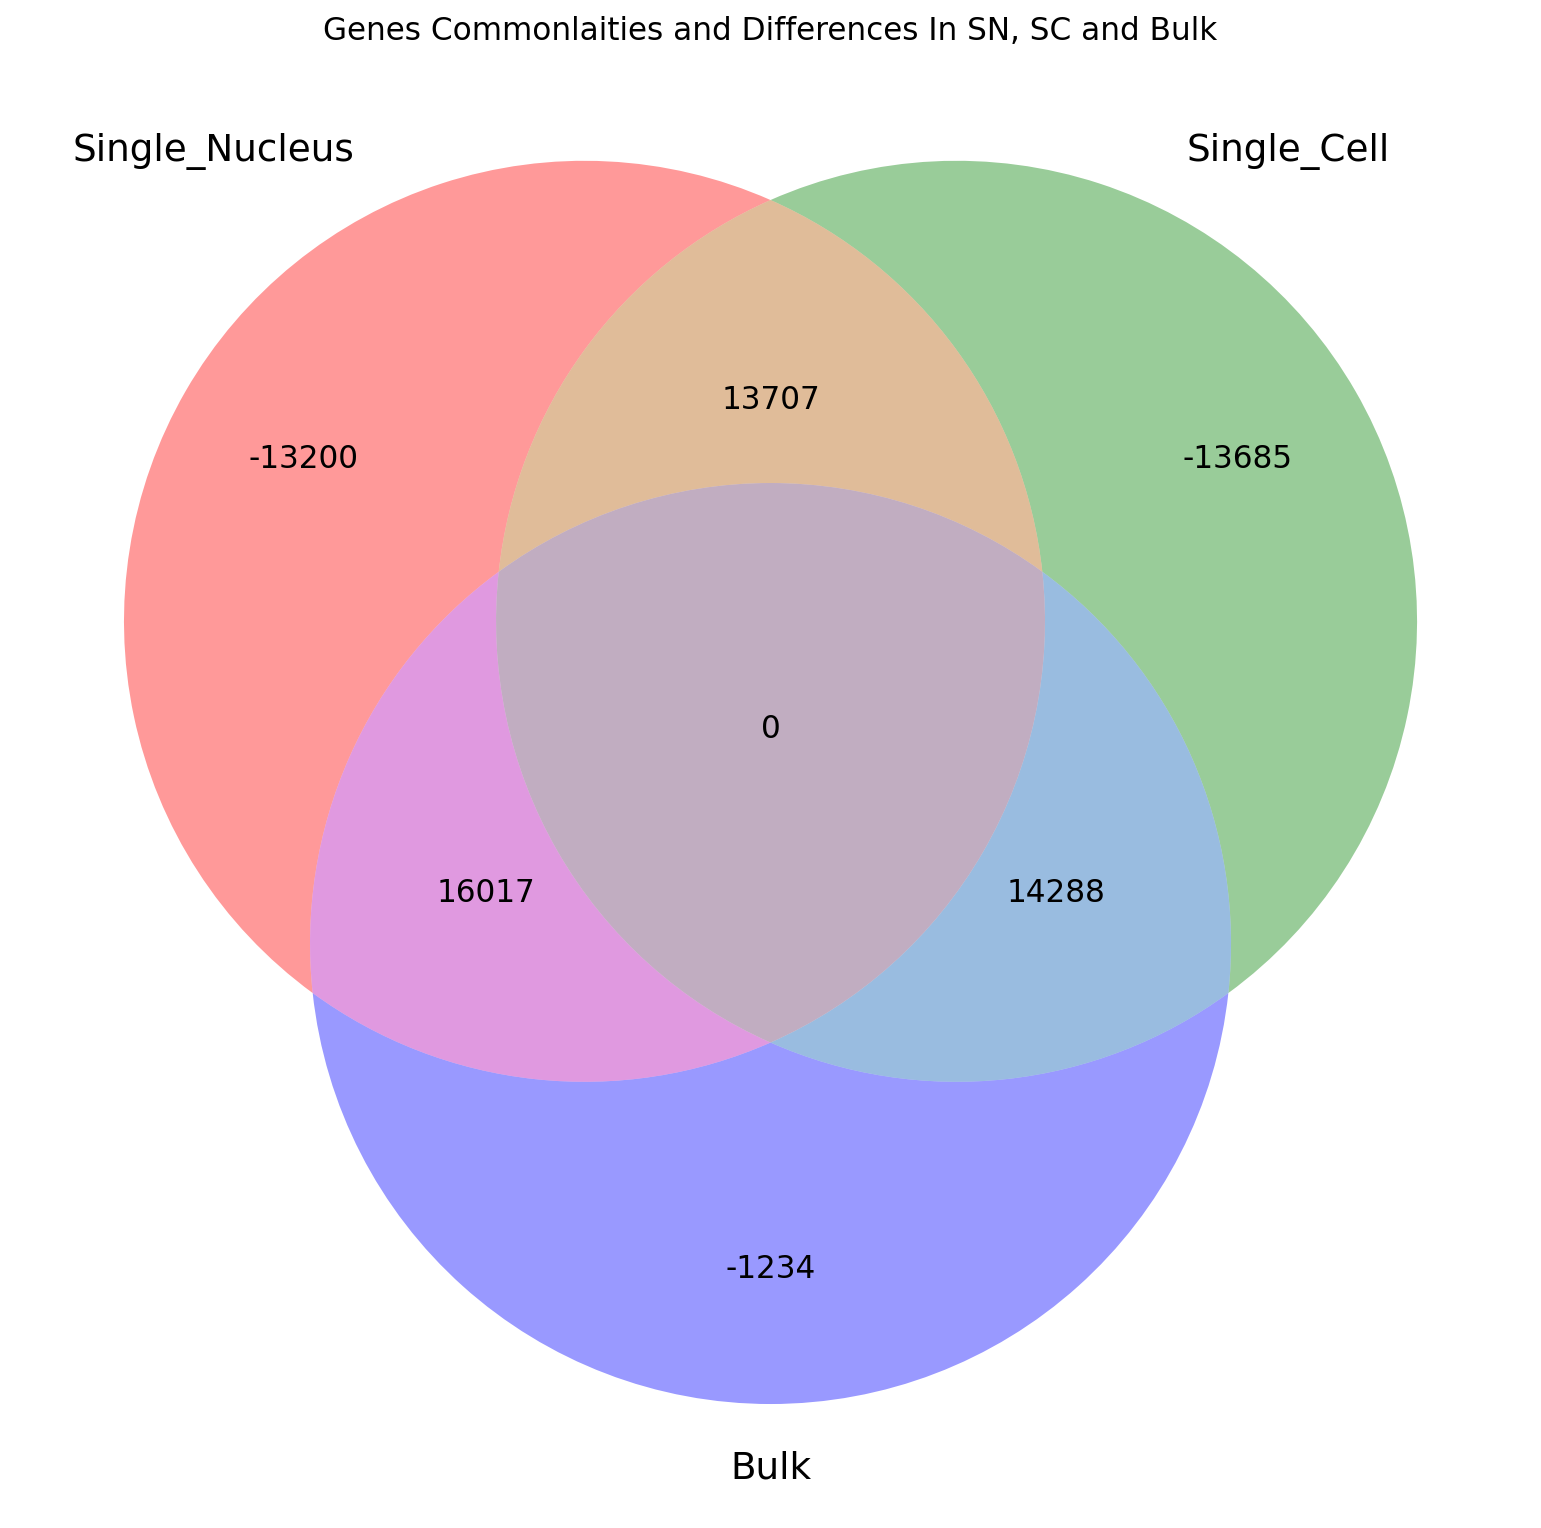

In [245]:
#common genes between SN and Bulk
common_genes_snwbulk = np.intersect1d(sn_genes.columns, bulk_genes.columns)
common_genes_snwbulk = list(common_genes_snwbulk)
#common genes between SC and Bulk
common_genes_scwbulk = np.intersect1d(sc_genes.columns, bulk_genes.columns)
common_genes_scwbulk = list(common_genes_scwbulk)

#common genes between bulk, SN, and SC.
len(common_genes_wbulk)

#common genes between SN and SC only, no bulk.
len(common_genes)

#calculating variables to plot on Venn and see gene discrepancies.
val5 =  len(np.setxor1d(common_genes_wbulk, common_genes_snwbulk))
val6 =  len(np.setxor1d(common_genes_wbulk, common_genes_scwbulk))
val3 = len(common_genes) - len(common_genes_wbulk)
val7 = len(common_genes_wbulk)
val4= bulk_genes.shape[1] - val7 - val5 - val6
val7 = len(common_genes_wbulk)
val1 = sn_genes.shape[1] - val3 - val7 - val5
val2 = sc_genes.shape[1] -  val3 - val7 - val6

#venn diagram for gene discrepancies
plt.figure(figsize=(15,12))  
gene_venn = venn3_unweighted(subsets =(val1, 
                            val2,
                            val3,
                            val4,
                            val5,
                            val6,
                            val7), 
                              set_labels = ('Single_Nucleus', 'Single_Cell', 'Bulk')
                            )
plt.title("Genes Commonlaities and Differences In SN, SC and Bulk")                  
plt.show()

In [246]:
#Code based from https://github.com/scverse/anndata/issues/73 falexwolf commented on Oct 20, 2018
#trimming down the sc_adata to contain only the genes available in common_genes SN and SC
common_gene_indicator = np.in1d(sc_adata.var_names, common_genes)
sc_adata = sc_adata[:, common_gene_indicator]
sc_adata

View of AnnData object with n_obs × n_vars = 4606 × 13707
    obs: 'cell_type'

In [247]:
#Code based from https://github.com/scverse/anndata/issues/73 falexwolf commented on Oct 20, 2018
#trimming down the sn_adta to contain only genes available in common_genes SN and SC
common_gene_indicator = np.in1d(sn_adata.var_names, common_genes)
sn_adata = sn_adata[:, common_gene_indicator]
sn_adata

View of AnnData object with n_obs × n_vars = 8611 × 13707
    obs: 'cell_type'

QCing the single nucleus data first:

/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


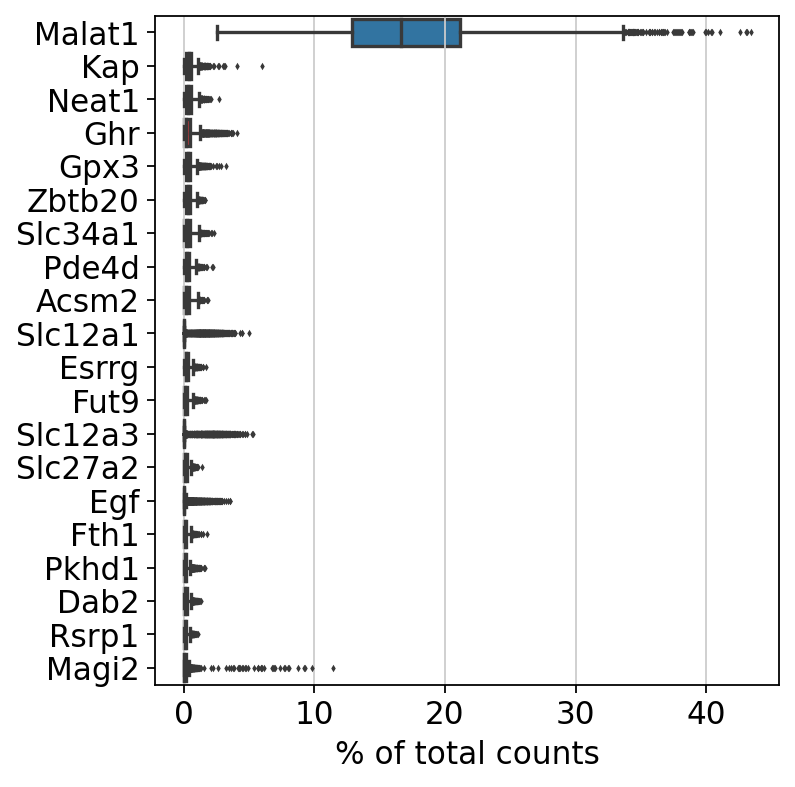

In [248]:
sc.pl.highest_expr_genes(sn_adata, n_top=20, )

In [249]:
# sc.pp.filter_cells(sn_adata, min_genes=200)
# sc.pp.filter_genes(sn_adata, min_cells=3)

In [250]:
sn_adata.var['mt'] = sn_adata.var_names.str.startswith('Mt')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(sn_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical


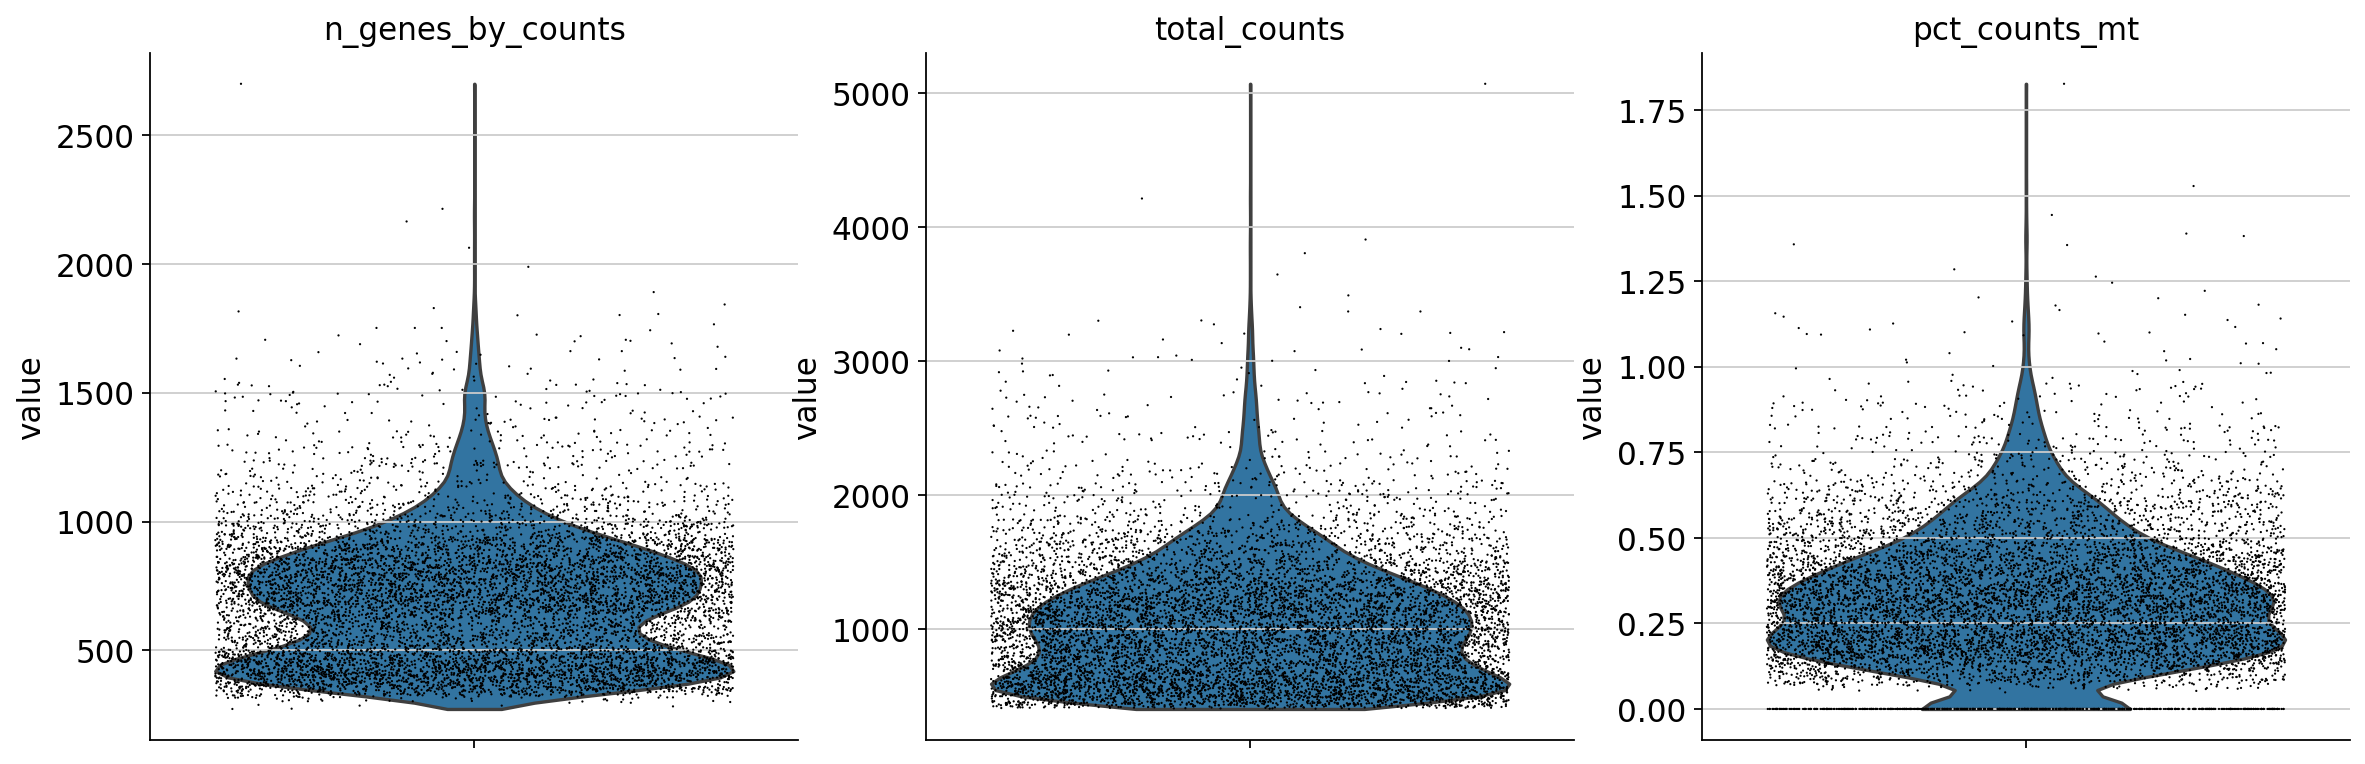

In [251]:
sc.pl.violin(sn_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

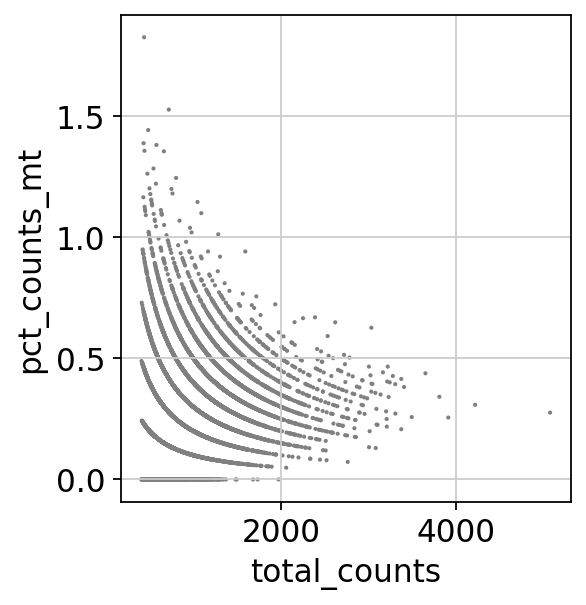

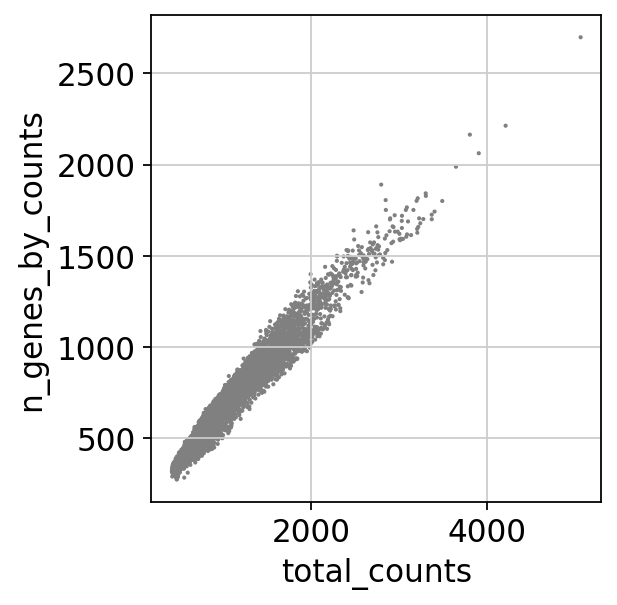

In [252]:
sc.pl.scatter(sn_adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(sn_adata, x='total_counts', y='n_genes_by_counts')

In [253]:
# sn_data = sn_adata[sn_adata.obs.n_genes_by_counts < 2000, :]
# sn_adata = sn_adata[sn_adata.obs.pct_counts_mt < 1.5, :]

In [254]:
sn_adata

AnnData object with n_obs × n_vars = 8611 × 13707
    obs: 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [255]:
sc.pp.normalize_total(sn_adata, target_sum=1e4)
sc.pp.log1p(sn_adata)

normalizing counts per cell
    finished (0:00:00)


In [256]:
sc.pp.highly_variable_genes(sn_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


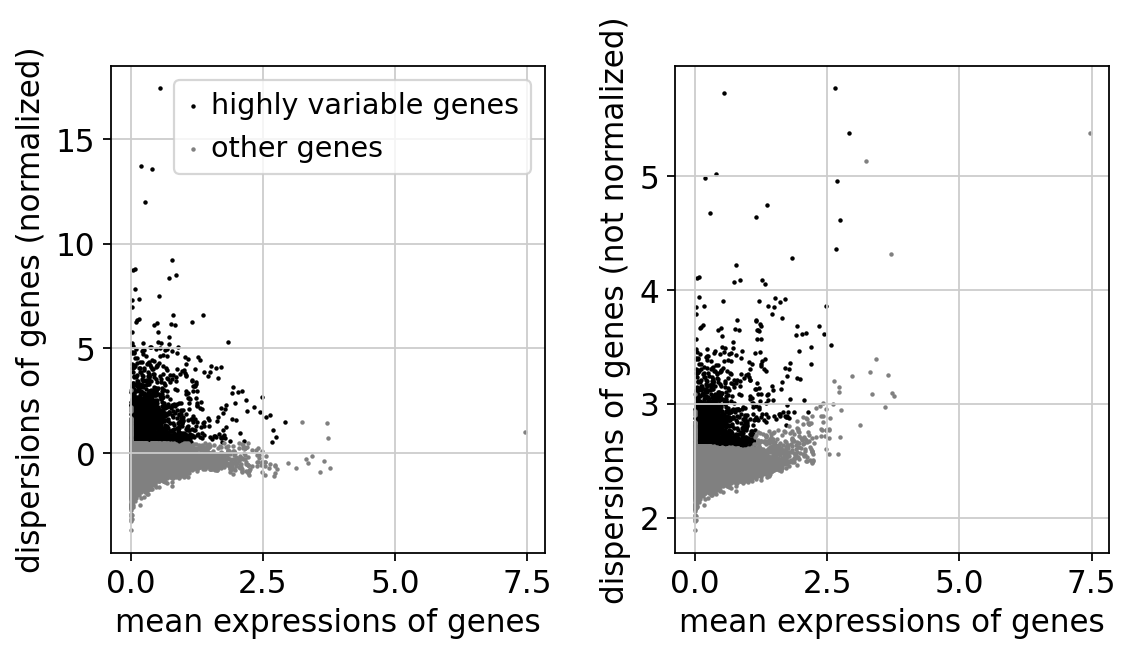

In [257]:
sc.pl.highly_variable_genes(sn_adata)

In [258]:
#sn_adata = sn_adata[:, sn_adata.var.highly_variable]

In [259]:
sn_adata

AnnData object with n_obs × n_vars = 8611 × 13707
    obs: 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [260]:
sc.pp.regress_out(sn_adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:02:07)


In [261]:
sc.pp.scale(sn_adata, max_value=10)

Now QC the single-cell dataset:

/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


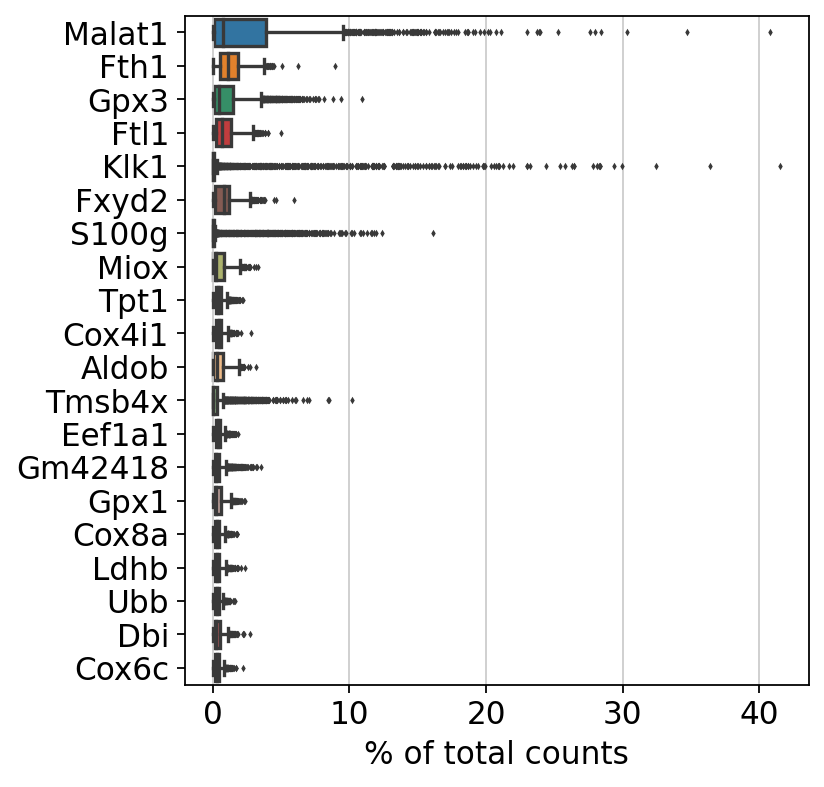

In [262]:
sc.pl.highest_expr_genes(sc_adata, n_top=20, )

In [263]:
sc.pp.filter_cells(sc_adata, min_genes=200)
sc.pp.filter_genes(sc_adata, min_cells=3)

filtered out 16 cells that have less than 200 genes expressed
filtered out 357 genes that are detected in less than 3 cells


In [264]:
sc_adata.var['mt'] = sc_adata.var_names.str.startswith('Mt')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(sc_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical


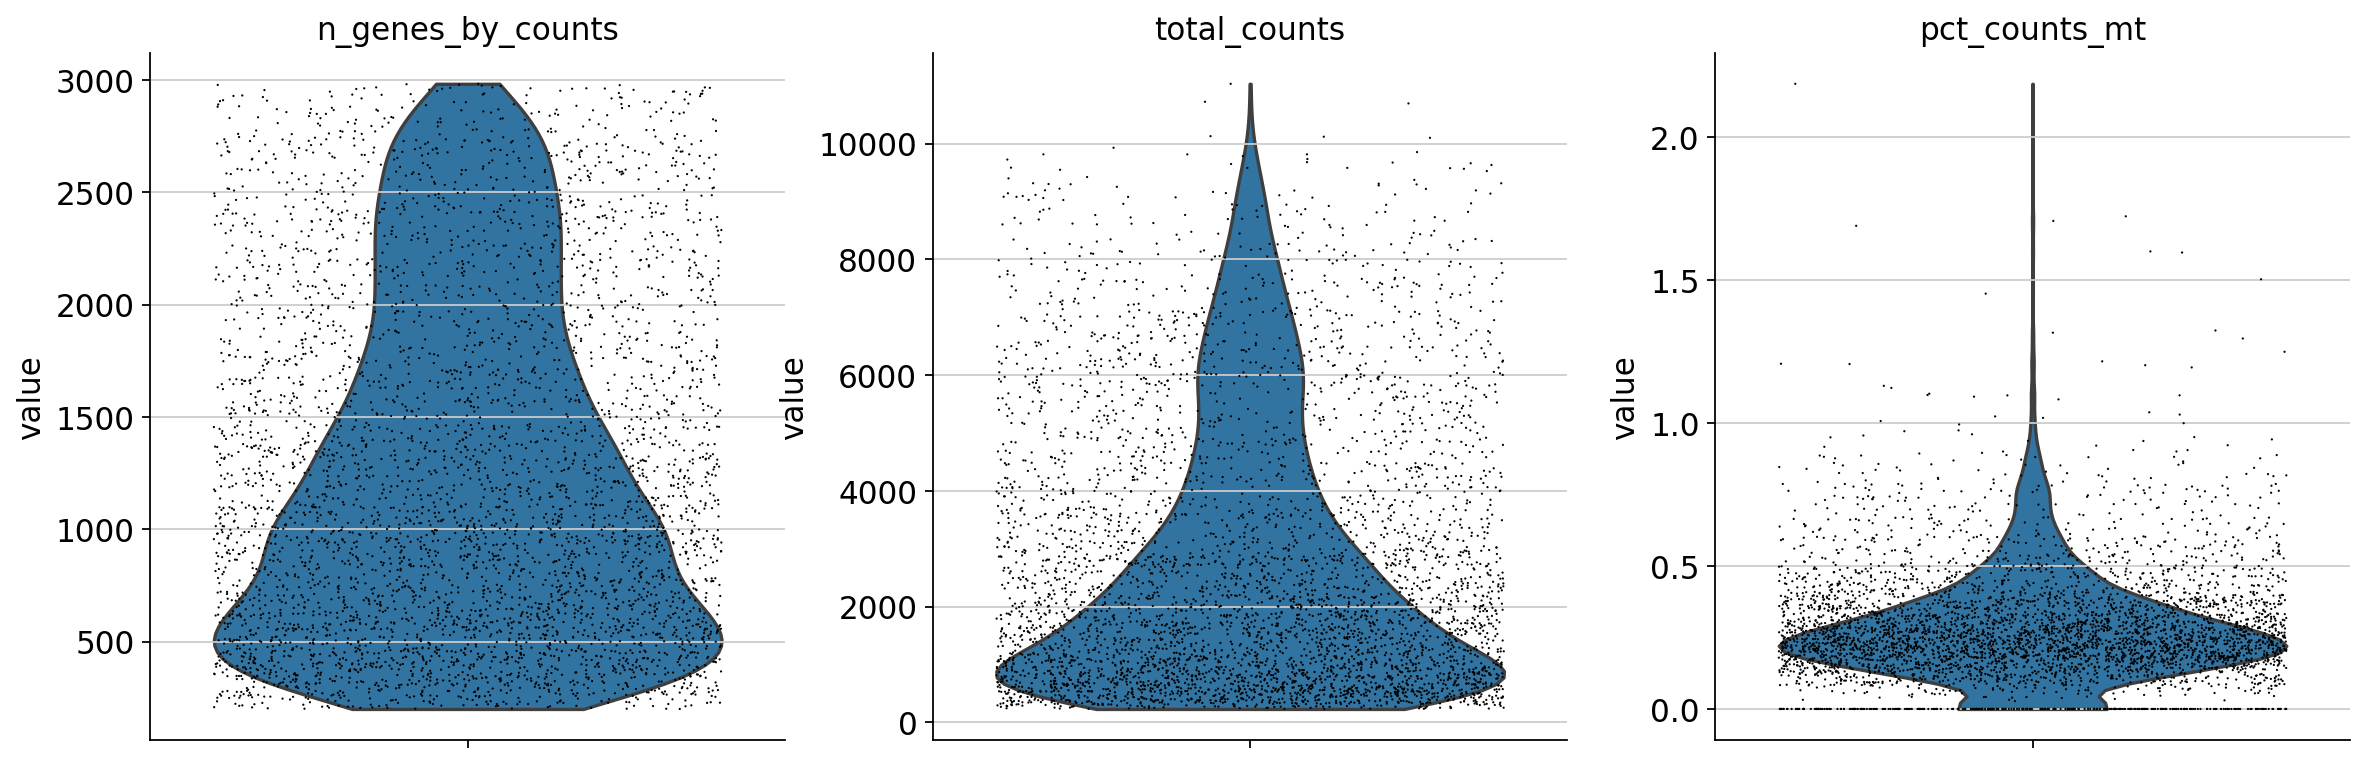

In [265]:
sc.pl.violin(sc_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

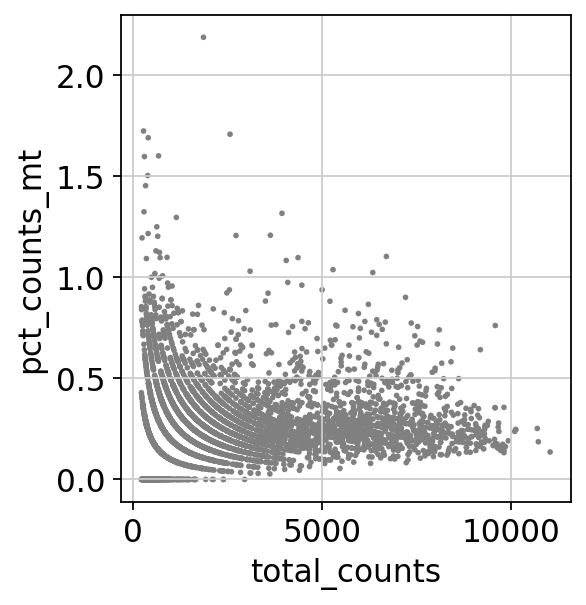

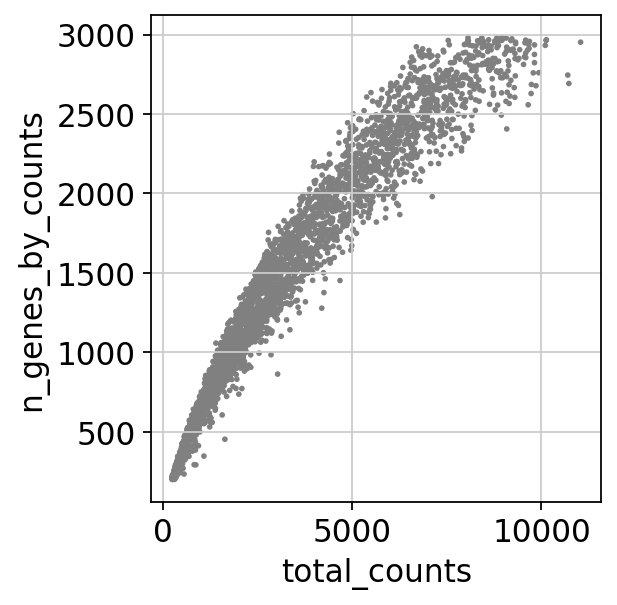

In [266]:
sc.pl.scatter(sc_adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(sc_adata, x='total_counts', y='n_genes_by_counts')

In [267]:
# sc_data = sc_adata[sc_adata.obs.n_genes_by_counts < 10000, :]
# sc_adata = sc_adata[sc_adata.obs.pct_counts_mt < 1, :]

In [268]:
#normalize and logarize:
sc.pp.normalize_total(sc_adata, target_sum=1e4)
sc.pp.log1p(sc_adata)

normalizing counts per cell
    finished (0:00:00)


In [269]:
sc.pp.highly_variable_genes(sc_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


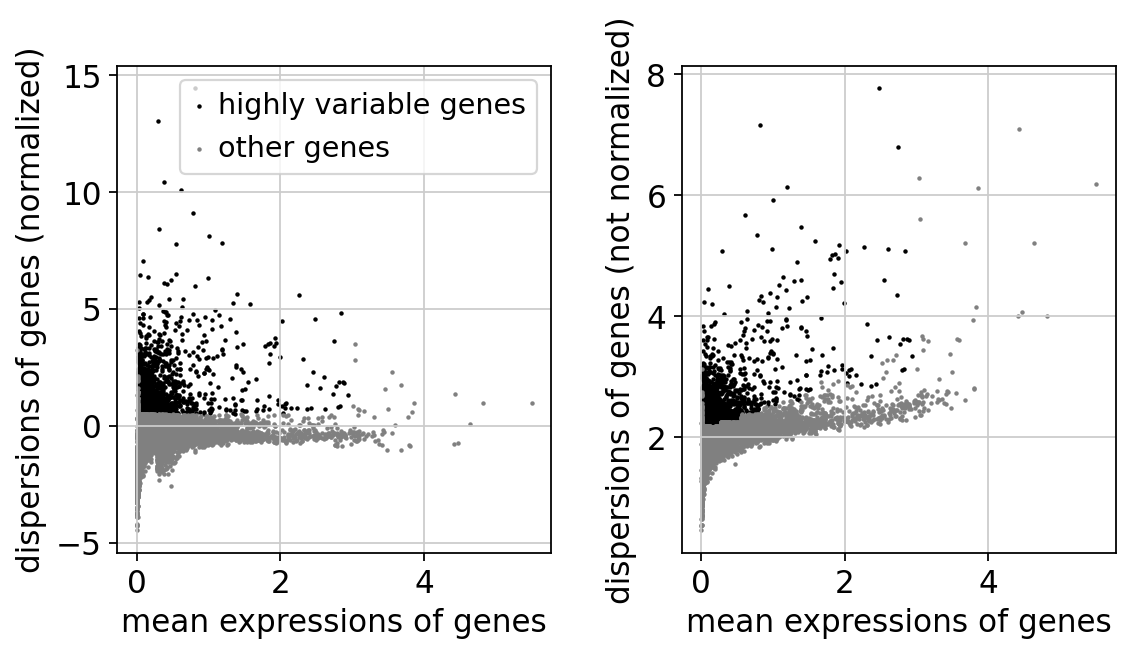

In [270]:
sc.pl.highly_variable_genes(sc_adata)

In [271]:
#sc_adata = sc_adata[:, sc_adata.var.highly_variable]
sc.pp.regress_out(sc_adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(sc_adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:01:33)


and now QCing the bulk dataset:

normalizing counts per cell
    finished (0:00:00)


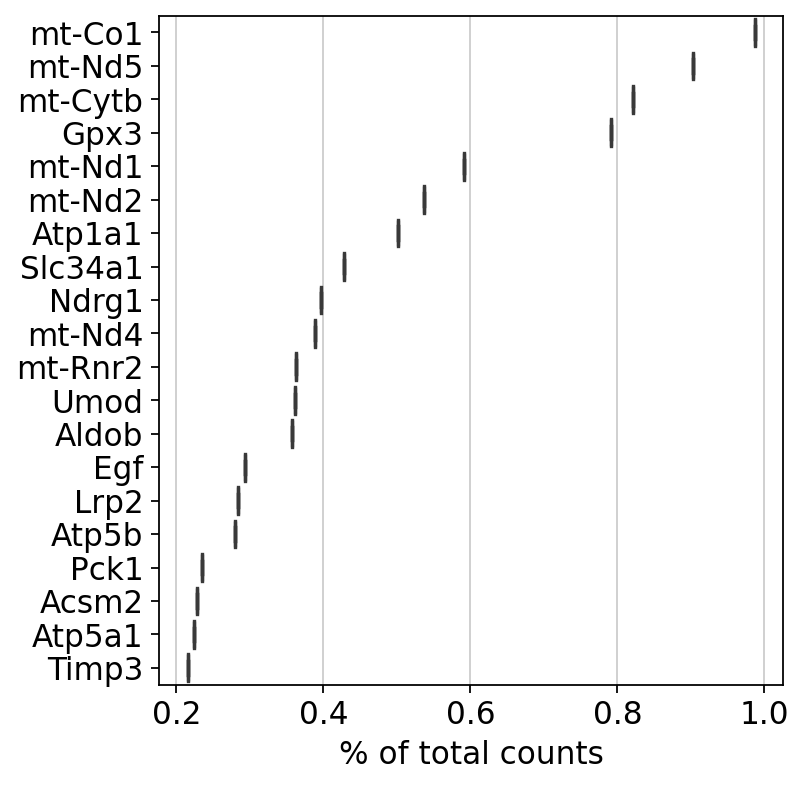

In [272]:
sc.pl.highest_expr_genes(bulk_adata, n_top=20, )

In [273]:
bulk_adata.var['mt'] = bulk_adata.var_names.str.startswith('Mt')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(bulk_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

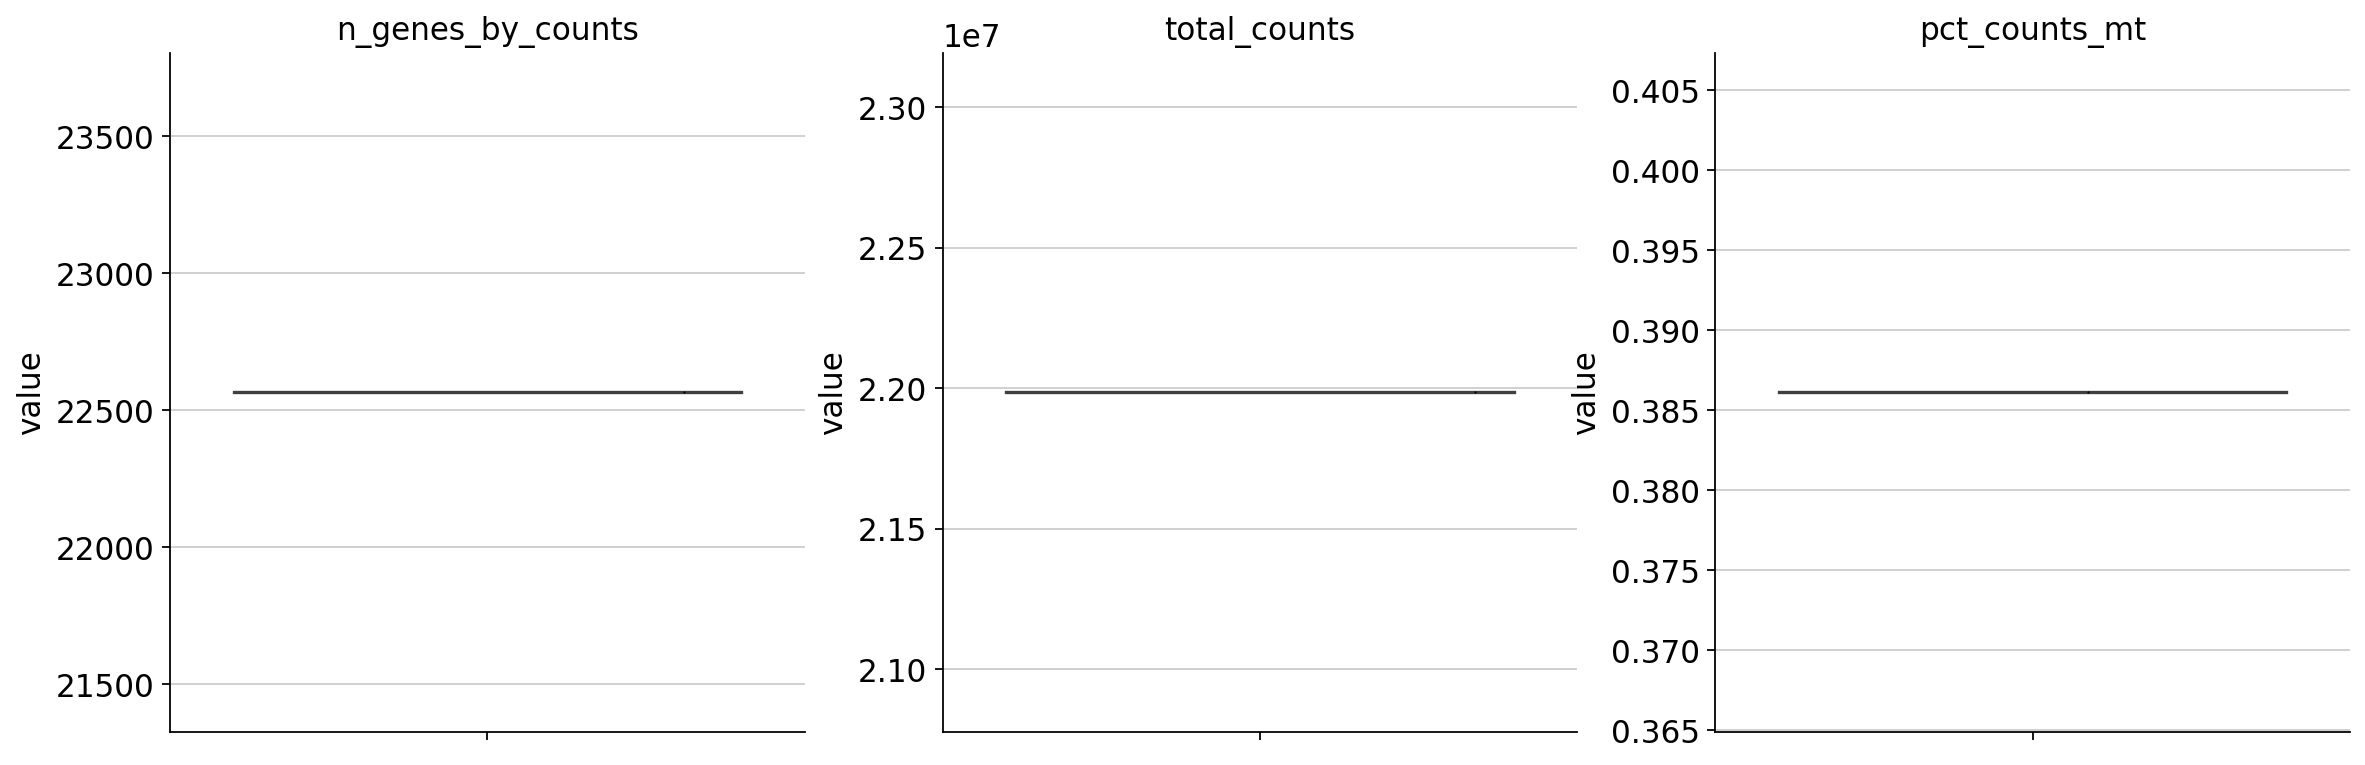

In [274]:
sc.pl.violin(bulk_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

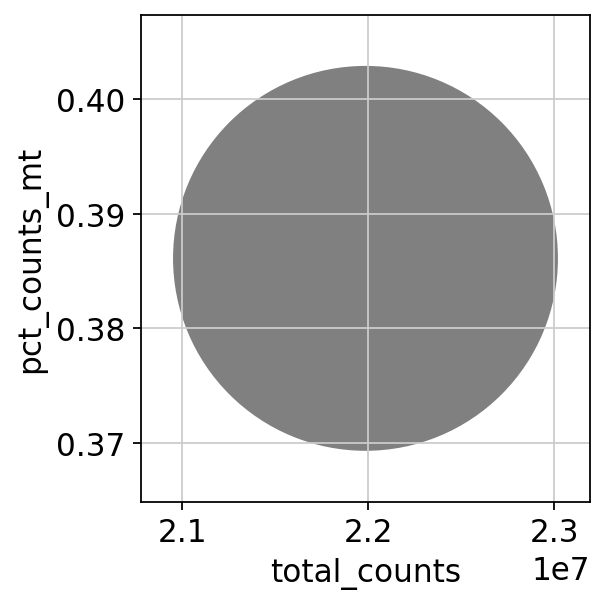

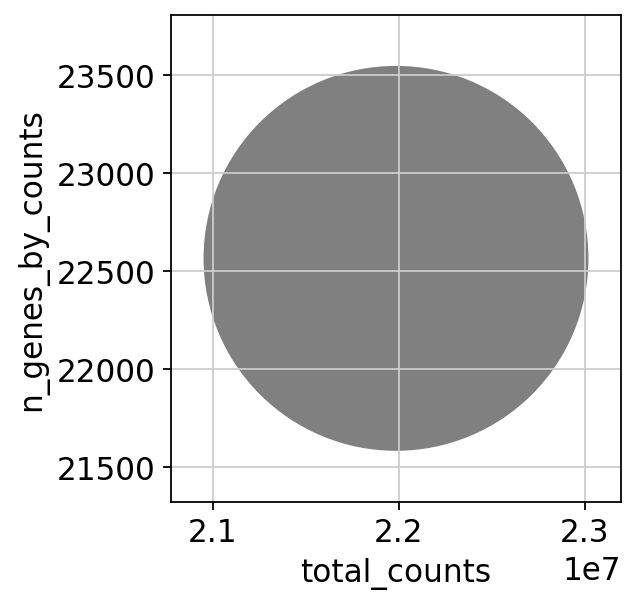

In [275]:
sc.pl.scatter(bulk_adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(bulk_adata, x='total_counts', y='n_genes_by_counts')

In [276]:
#normalize and logarize:
sc.pp.normalize_total(bulk_adata, target_sum=1e4)
sc.pp.log1p(bulk_adata)
sc.pp.regress_out(bulk_adata, ['total_counts', 'pct_counts_mt'])

normalizing counts per cell
    finished (0:00:00)
regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:00)


In [ ]:
sn_genes = pd.DataFrame(sn_adata.var) 
sc_genes = pd.DataFrame(sc_adata.var)
bulk_genes = pd.DataFrame(bulk_adata.var)
sn_genes = sn_genes.transpose()
sc_genes = sc_genes.transpose()
bulk_genes = bulk_genes.transpose()

In [ ]:
#common genes between SN and Bulk
common_genes_snwbulk = np.intersect1d(sn_genes.columns, bulk_genes.columns)
common_genes_snwbulk = list(common_genes_snwbulk)
#common genes between SC and Bulk
common_genes_scwbulk = np.intersect1d(sc_genes.columns, bulk_genes.columns)
common_genes_scwbulk = list(common_genes_scwbulk)

common_genes = np.intersect1d(sc_genes.columns, sn_genes.columns)
common_genes= list(common_genes)

common_genes_wbulk = np.intersect1d(common_genes, bulk_genes.columns)
common_genes_wbulk= list(common_genes_wbulk)

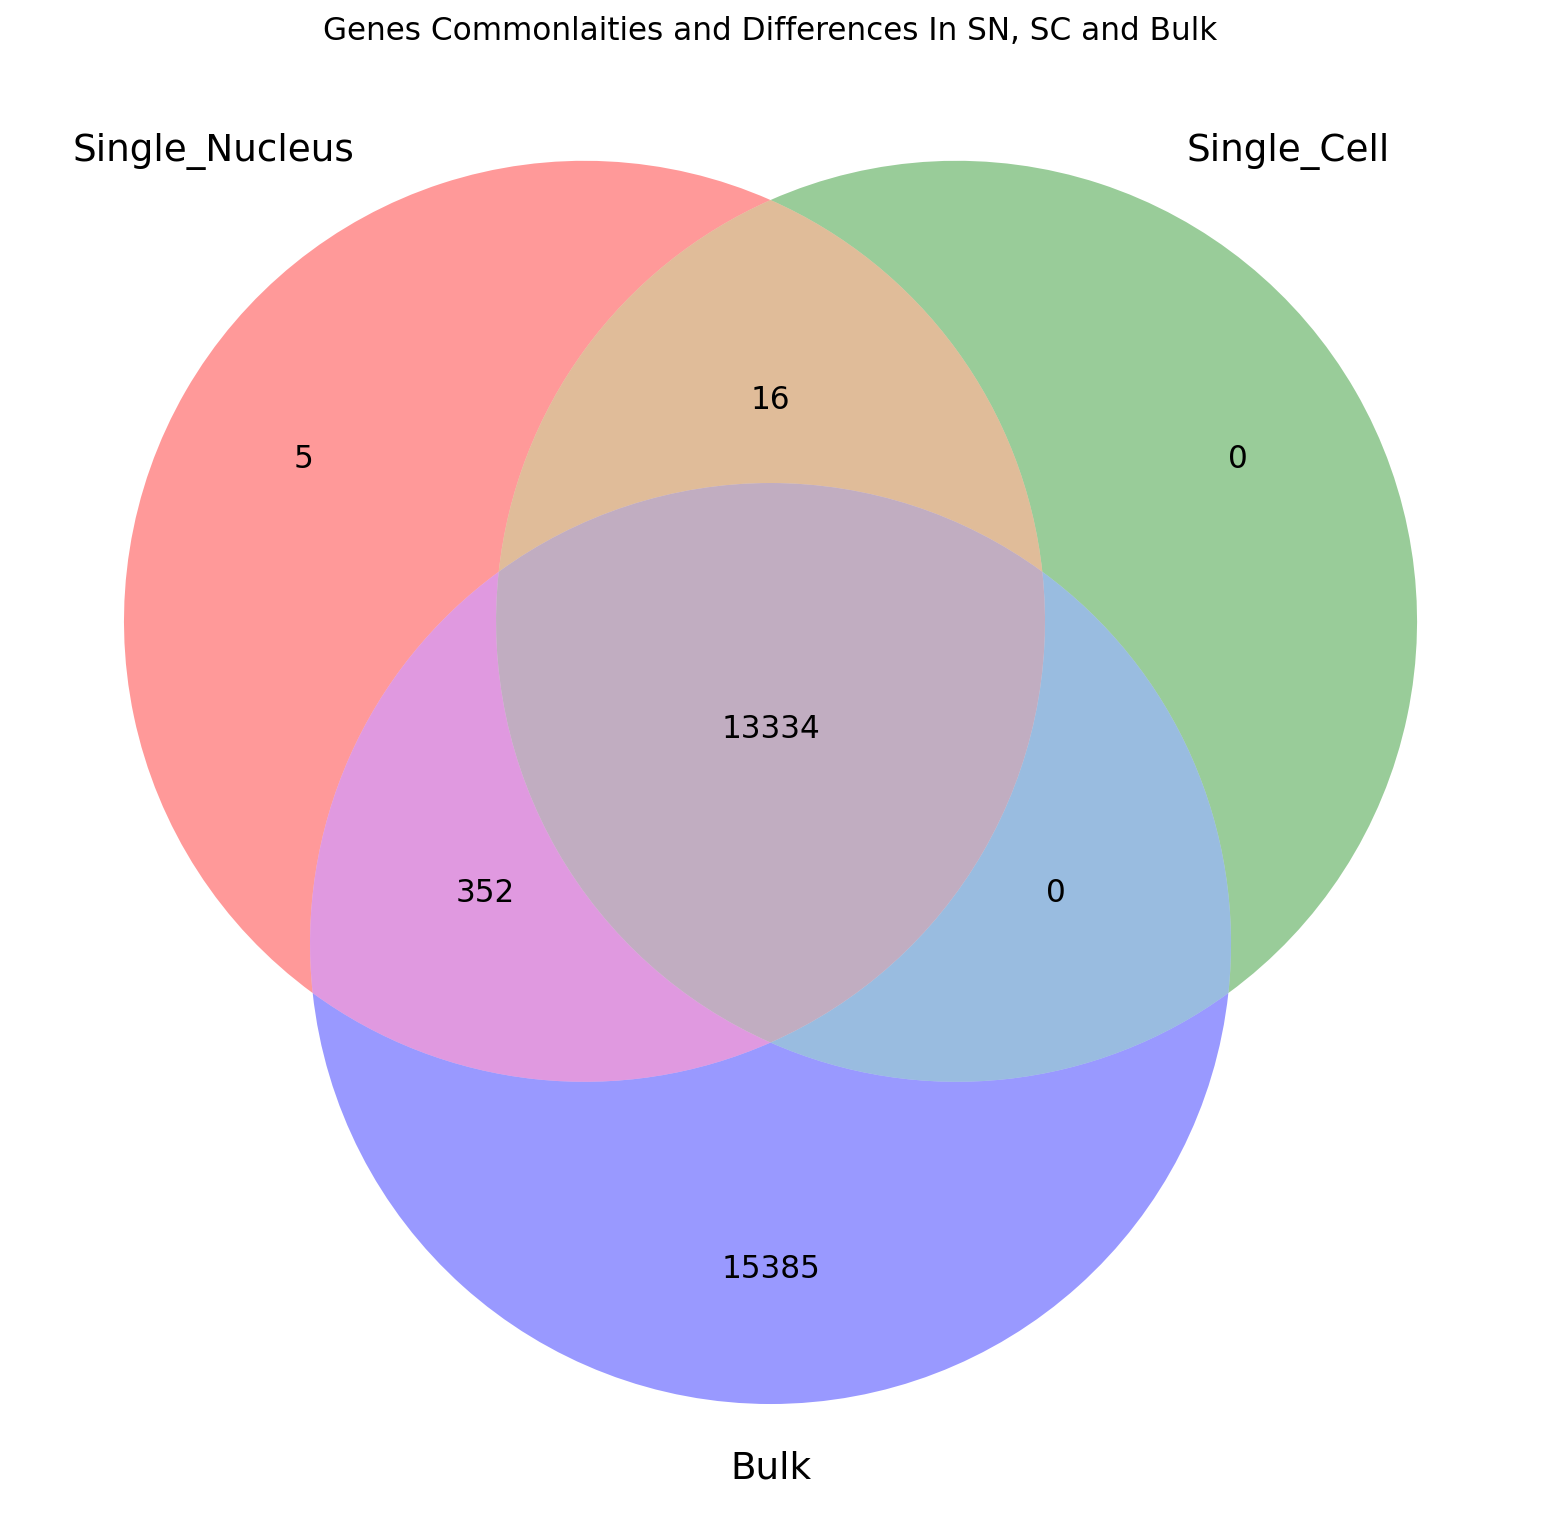

In [ ]:
#common genes between bulk, SN, and SC.
len(common_genes_wbulk)

#common genes between SN and SC only, no bulk.
len(common_genes)

#calculating variables to plot on Venn and see gene discrepancies.
val5 =  len(np.setxor1d(common_genes_wbulk, common_genes_snwbulk))
val6 =  len(np.setxor1d(common_genes_wbulk, common_genes_scwbulk))
val3 = len(common_genes) - len(common_genes_wbulk)
val7 = len(common_genes_wbulk)
val4= bulk_genes.shape[1] - val7 - val5 - val6
val7 = len(common_genes_wbulk)
val1 = sn_genes.shape[1] - val3 - val7 - val5
val2 = sc_genes.shape[1] -  val3 - val7 - val6

#venn diagram for gene discrepancies
plt.figure(figsize=(15,12))  
gene_venn = venn3_unweighted(subsets =(val1, 
                            val2,
                            val3,
                            val4,
                            val5,
                            val6,
                            val7), 
                              set_labels = ('Single_Nucleus', 'Single_Cell', 'Bulk')
                            )
plt.title("Genes Commonlaities and Differences In SN, SC and Bulk")                  
plt.show()

Computing Clustering:

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:18)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


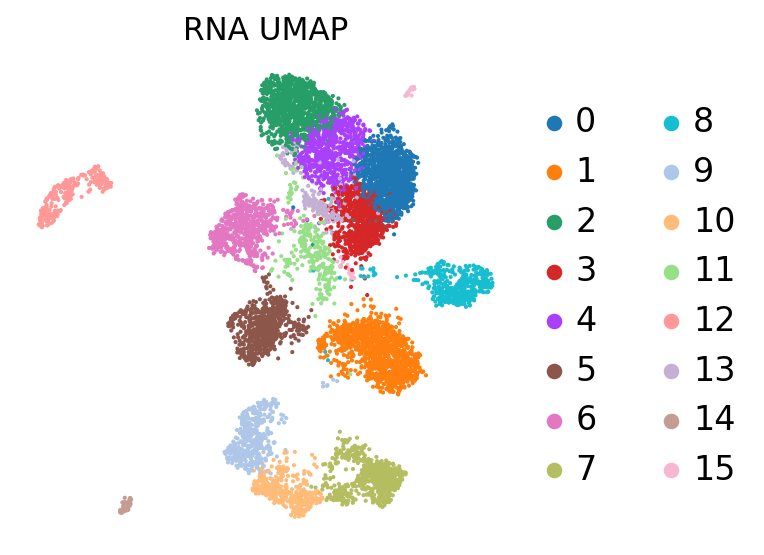

In [ ]:
# Generate PCA features
sc.tl.pca(sn_adata , svd_solver='arpack')

# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(sn_adata , n_neighbors=5, n_pcs=40)

# Generate UMAP features
sc.tl.umap(sn_adata )

# Run leiden clustering algorithm
sc.tl.leiden(sn_adata)
#sc.tl.louvain(sn_adata)

# Visualize
sc.pl.umap(sn_adata, color='leiden', title='RNA UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
running Leiden clustering
    finished: found 30 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


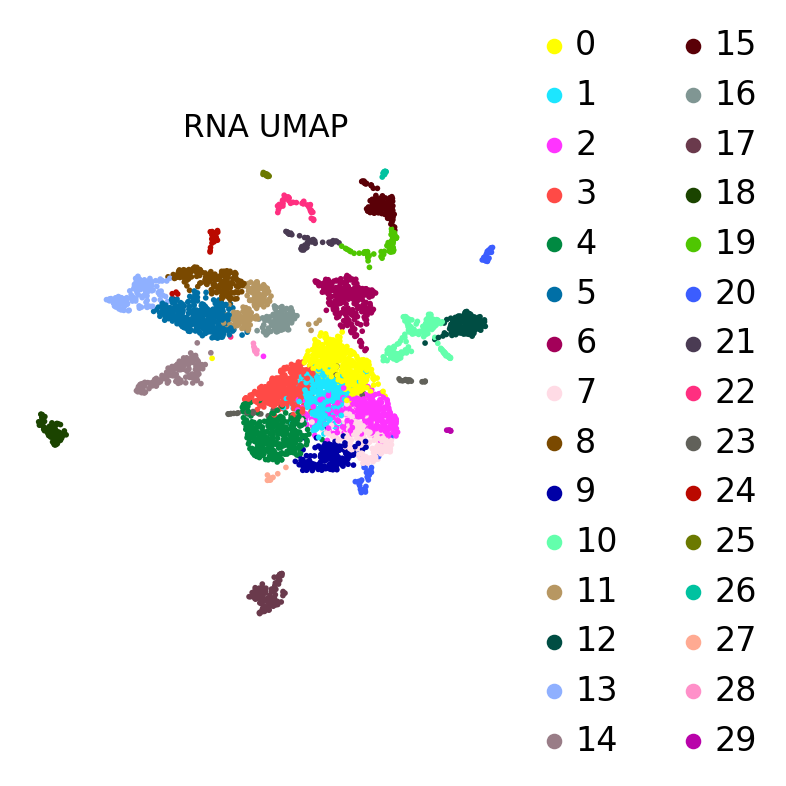

In [ ]:
# Generate PCA features
sc.tl.pca(sc_adata, svd_solver='arpack')

# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(sc_adata, n_neighbors=5, n_pcs=40)

# Generate UMAP features
sc.tl.umap(sc_adata)

# Run leiden and louvain clustering algorithm
sc.tl.leiden(sc_adata)
#sc.tl.louvain(sc_adata)

# Visualize
sc.pl.umap(sc_adata, color='leiden', title='RNA UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

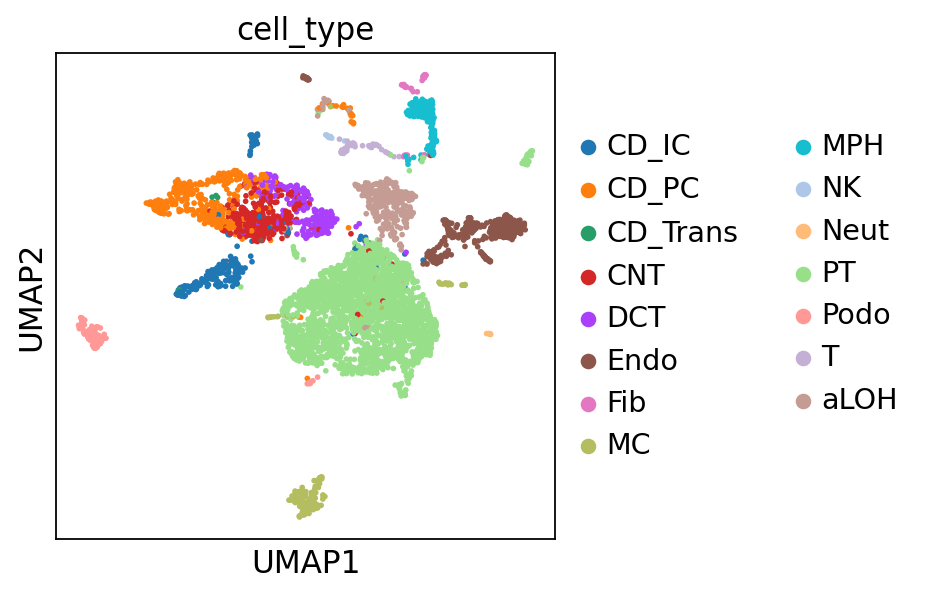

In [ ]:
# Visualize cell assignments:
sc.pl.umap(sc_adata, color='cell_type')

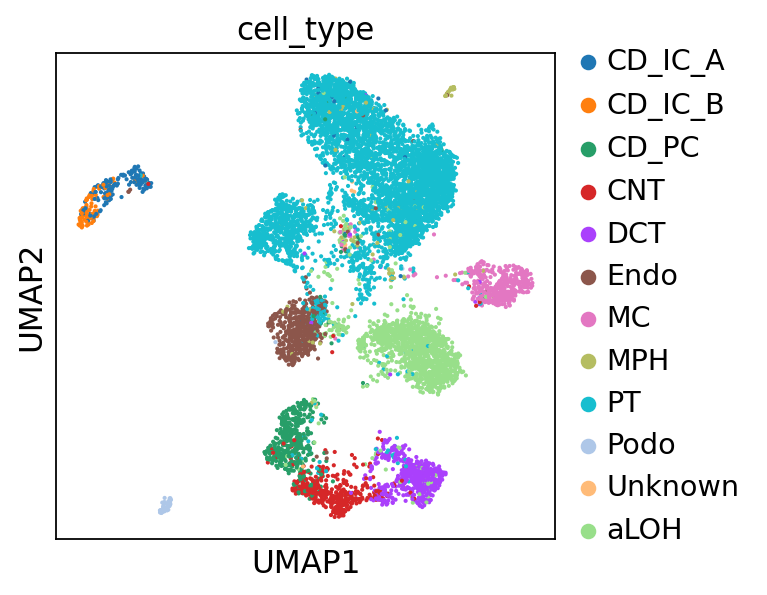

In [ ]:
# Visualize cell assignments:
sc.pl.umap(sn_adata, color='cell_type')

B, B cells; 

CD-IC, collecting duct intercalated cells; 

CD-PC, collecting duct principal cells; 

CNT-CDT, connecting tubule and distal convoluted tubule cells; 

damaged PT, damaged proximal tubular cells; 

DC, dendritic cells; 

Endo, endothelial cells; 

LOH, loop of Henle cells; 

MΦ, macrophages; 

Mes, mesangial cells; 

NK, natural killer cells; 

Neutro, neutrophilic granulocytes; 

Podo, podocytes; 

PT, proximal tubular cells; 

T, T cells.


Matching cell types for comparison:

In [ ]:
Counter(sn_adata.obs['cell_type'])

Counter({'aLOH': 1253,
         'PT': 4671,
         'CD_PC': 433,
         'DCT': 528,
         'MC': 403,
         'CNT': 396,
         'Podo': 46,
         'Endo': 524,
         'CD_IC_A': 179,
         'MPH': 83,
         'CD_IC_B': 84,
         'Unknown': 11})

In [ ]:
new_cell_names_sn = dict(aLOH = 'aLOH',
                     PT = 'PT',
                     CD_PC = 'CD_PC',
                     DCT = 'DCT', 
                     MC = 'MC',
                     CNT = 'CNT', 
                     Podo = 'Podo', 
                     Endo = 'Endo', 
                     CD_IC_A = 'CD_IC', 
                     MPH = 'MPH',
                     CD_IC_B= 'CD_IC',
                     Unknown = 'Unknown')

sn_adata.obs['cell_type'] = (
    sn_adata.obs['cell_type']
    .map(new_cell_names_sn )
    .astype('category')
)


In [ ]:
Counter(sn_adata.obs['cell_type'])

Counter({'aLOH': 1253,
         'PT': 4671,
         'CD_PC': 433,
         'DCT': 528,
         'MC': 403,
         'CNT': 396,
         'Podo': 46,
         'Endo': 524,
         'CD_IC': 263,
         'MPH': 83,
         'Unknown': 11})

In [ ]:
Counter(sc_adata.obs['cell_type'])

Counter({'CD_IC': 216,
         'CNT': 305,
         'PT': 2312,
         'CD_PC': 375,
         'MC': 142,
         'Endo': 334,
         'DCT': 234,
         'Podo': 98,
         'aLOH': 316,
         'MPH': 156,
         'CD_Trans': 5,
         'NK': 11,
         'Fib': 33,
         'T': 46,
         'Neut': 7})

In [ ]:
new_cell_names_sc = dict(
         CD_IC= 'CD_IC',
         CNT = 'CNT',
         PT= 'PT',
         CD_PC = 'CD_PC',
         MC = 'MC',
         Endo = 'Endo',
         DCT= 'DCT',
         Podo = 'Podo',
         aLOH = 'aLOH',
         MPH = 'MPH',
         CD_Trans= 'CD_Trans',
         NK = 'NK',
         Fib = 'Fib',
         T = 'T',
         Neut = 'Neut')

sc_adata.obs['cell_type'] = (
    sc_adata.obs['cell_type']
    .map(new_cell_names_sc )
    .astype('category')
)


In [ ]:
sn_props = make_prop_table(sn_adata, 'cell_type')

╒════╤══════════════╤═════════════╤══════════════╕
│    │ Cell_Types   │   Num_Cells │   Prop_Cells │
╞════╪══════════════╪═════════════╪══════════════╡
│  0 │ aLOH         │        1253 │   0.145512   │
├────┼──────────────┼─────────────┼──────────────┤
│  1 │ PT           │        4671 │   0.542446   │
├────┼──────────────┼─────────────┼──────────────┤
│  2 │ CD_PC        │         433 │   0.0502845  │
├────┼──────────────┼─────────────┼──────────────┤
│  3 │ DCT          │         528 │   0.0613169  │
├────┼──────────────┼─────────────┼──────────────┤
│  4 │ MC           │         403 │   0.0468006  │
├────┼──────────────┼─────────────┼──────────────┤
│  5 │ CNT          │         396 │   0.0459877  │
├────┼──────────────┼─────────────┼──────────────┤
│  6 │ Podo         │          46 │   0.005342   │
├────┼──────────────┼─────────────┼──────────────┤
│  7 │ Endo         │         524 │   0.0608524  │
├────┼──────────────┼─────────────┼──────────────┤
│  8 │ CD_IC        │         2

In [ ]:
sc_props = make_prop_table(sc_adata, 'cell_type')

╒════╤══════════════╤═════════════╤══════════════╕
│    │ Cell_Types   │   Num_Cells │   Prop_Cells │
╞════╪══════════════╪═════════════╪══════════════╡
│  0 │ CD_IC        │         216 │   0.0470588  │
├────┼──────────────┼─────────────┼──────────────┤
│  1 │ CNT          │         305 │   0.0664488  │
├────┼──────────────┼─────────────┼──────────────┤
│  2 │ PT           │        2312 │   0.503704   │
├────┼──────────────┼─────────────┼──────────────┤
│  3 │ CD_PC        │         375 │   0.0816993  │
├────┼──────────────┼─────────────┼──────────────┤
│  4 │ MC           │         142 │   0.0309368  │
├────┼──────────────┼─────────────┼──────────────┤
│  5 │ Endo         │         334 │   0.0727669  │
├────┼──────────────┼─────────────┼──────────────┤
│  6 │ DCT          │         234 │   0.0509804  │
├────┼──────────────┼─────────────┼──────────────┤
│  7 │ Podo         │          98 │   0.0213508  │
├────┼──────────────┼─────────────┼──────────────┤
│  8 │ aLOH         │         3

In [ ]:
sn_props.sort_values('Cell_Types')

Cell_Types  Num_Cells  Prop_Cells
8       CD_IC        263    0.030542
2       CD_PC        433    0.050285
5         CNT        396    0.045988
3         DCT        528    0.061317
7        Endo        524    0.060852
4          MC        403    0.046801
9         MPH         83    0.009639
1          PT       4671    0.542446
6        Podo         46    0.005342
11      Total       8611    1.000000
10    Unknown         11    0.001277
0        aLOH       1253    0.145512

In [ ]:
sc_props.sort_values('Cell_Types')

Cell_Types  Num_Cells  Prop_Cells
0       CD_IC        216    0.047059
3       CD_PC        375    0.081699
10   CD_Trans          5    0.001089
1         CNT        305    0.066449
6         DCT        234    0.050980
5        Endo        334    0.072767
12        Fib         33    0.007190
4          MC        142    0.030937
9         MPH        156    0.033987
11         NK         11    0.002397
14       Neut          7    0.001525
2          PT       2312    0.503704
7        Podo         98    0.021351
13          T         46    0.010022
15      Total       4590    1.000000
8        aLOH        316    0.068845

To compare, we're mergint the satasets together, but keeping origin as an obs.

In [ ]:
sn_adata.obs['orig'] = 'single_nucleus'
together_sn = list()
counter_sn = 0
for value in sn_adata.obs['orig']:
    together_sn.append(f"{value}_{sn_adata.obs['cell_type'][counter_sn]}")
    counter_sn = counter_sn+1
together_sn   

['single_nucleus_aLOH',
 'single_nucleus_aLOH',
 'single_nucleus_aLOH',
 'single_nucleus_PT',
 'single_nucleus_aLOH',
 'single_nucleus_PT',
 'single_nucleus_CD_PC',
 'single_nucleus_PT',
 'single_nucleus_DCT',
 'single_nucleus_MC',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_aLOH',
 'single_nucleus_CNT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_DCT',
 'single_nucleus_DCT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_aLOH',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_Podo',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_Endo',
 'single_nucleus_aLOH',
 'single_nucleus_DCT',
 'single_nucleus_PT',
 'single_nucleus_DCT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_aLOH',
 'single_nucleus_aLOH',
 'single_nucleus_DCT',
 'single_nucleus_PT',
 'single_nucleus_PT',
 'single_nucleus_Endo',
 'single_nucleus_aLO

In [ ]:
sn_adata.obs['orig_and_celltype'] = together_sn

In [ ]:
sc_adata.obs['orig'] = 'single_cell'
together_sc = list()
counter_sc = 0
for value in sc_adata.obs['orig']:
    together_sc.append(f"{value}_{sc_adata.obs['cell_type'][counter_sc]}")
    counter_sc = counter_sc+1
together_sc   

['single_cell_CD_IC',
 'single_cell_CD_IC',
 'single_cell_CNT',
 'single_cell_PT',
 'single_cell_CD_PC',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_CD_IC',
 'single_cell_PT',
 'single_cell_MC',
 'single_cell_CNT',
 'single_cell_Endo',
 'single_cell_DCT',
 'single_cell_Podo',
 'single_cell_PT',
 'single_cell_aLOH',
 'single_cell_PT',
 'single_cell_DCT',
 'single_cell_DCT',
 'single_cell_MC',
 'single_cell_MPH',
 'single_cell_CD_IC',
 'single_cell_Podo',
 'single_cell_PT',
 'single_cell_CNT',
 'single_cell_PT',
 'single_cell_CNT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_CD_PC',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_CD_PC',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_DCT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cell_PT',
 'single_cel

In [ ]:
sc_adata.obs['orig_and_celltype'] = together_sc

In [ ]:
#now combining both anndatas, outer and inner (including mismatch vs not including mismatch):
single_adata_inner = sn_adata.concatenate(sc_adata, join='inner')
single_adata_inner

AnnData object with n_obs × n_vars = 13201 × 13350
    obs: 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'orig', 'orig_and_celltype', 'n_genes', 'batch'
    var: 'mt', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'mean-0', 'std-0', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'mean-1', 'std-1', 'n_cells-1'
    obsm: 'X_pca', 'X_umap'

In [ ]:
#now combining both anndatas, outer and inner (including mismatch vs not including mismatch):
single_adata_outer = sn_adata.concatenate(sc_adata, join='outer')
single_adata_outer

AnnData object with n_obs × n_vars = 13201 × 13707
    obs: 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'orig', 'orig_and_celltype', 'n_genes', 'batch'
    var: 'mt-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'mean-0', 'std-0', 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'mean-1', 'std-1', 'n_cells-1'
    obsm: 'X_pca', 'X_umap'

In [ ]:
Counter(single_adata_inner.obs['cell_type'])

Counter({'aLOH': 1569,
         'PT': 6983,
         'CD_PC': 808,
         'DCT': 762,
         'MC': 545,
         'CNT': 701,
         'Podo': 144,
         'Endo': 858,
         'CD_IC': 479,
         'MPH': 239,
         'Unknown': 11,
         'CD_Trans': 5,
         'NK': 11,
         'Fib': 33,
         'T': 46,
         'Neut': 7})

Computing average gene expression per cell type and origin:

In [ ]:
single_adata_inner.obs['orig_and_celltype'] =  single_adata_inner.obs['orig_and_celltype'].astype('category')

In [ ]:
####Code altered from : https://scanpy.discourse.group/t/how-to-calculate-the-average-gene-expression-within-each-cluster/126/2
res_inner = pd.DataFrame(columns=single_adata_inner.var_names, index=single_adata_inner.obs['orig_and_celltype'].cat.categories) 
for clust in single_adata_inner.obs.orig_and_celltype.cat.categories: 
    res_inner.loc[clust] = single_adata_inner[single_adata_inner.obs['orig_and_celltype'].isin([clust]),:].X.mean(0)
#reordering columsn so they match    
res_inner = res_inner.reindex(sorted(res_inner.columns), axis=1)
res_inner  #res inner now contains the mean expression per gene of each cell type

0610007P14Rik 0610009B22Rik 0610009L18Rik  \
single_cell_CD_IC           -0.01709       0.09729     -0.101456   
single_cell_CD_PC           0.144851      -0.09161      0.105742   
single_cell_CD_Trans       -0.360056     -0.206036       0.93643   
single_cell_CNT            -0.102943      0.124871      0.176535   
single_cell_DCT            -0.061861      0.091742      0.049945   
single_cell_Endo             0.09471     -0.149842     -0.156689   
single_cell_Fib             0.159107     -0.495742     -0.286291   
single_cell_MC             -0.031672      0.070279      0.296943   
single_cell_MPH            -0.071985     -0.294058      -0.13167   
single_cell_NK              0.339084     -0.434171     -0.189705   
single_cell_Neut           -0.244785     -0.353132     -0.134208   
single_cell_PT             -0.012431       0.04703     -0.026359   
single_cell_Podo           -0.133994      -0.10977      0.280083   
single_cell_T               0.352396     -0.363994     -0.102838   
single_cell_aLOH           -0.001476     -0.053382     -0.020714   
single_nucleus_CD_IC        0.219902     -0.048493      0.009589   
single_nucleus_CD_PC       -0.026208     -0.022325      0.101706   
single_nucleus_CNT          0.004235     -0.023184     -0.055296   
single_nucleus_DCT         -0.081638     -0.066299      -0.02242   
single_nucleus_Endo         0.019549      0.096894      -0.05681   
single_nucleus_MC           0.060934     -0.009722      -0.01482   
single_nucleus_MPH         -0.163455     -0.139816     -0.015212   
single_nucleus_PT          -0.015734      0.012247      0.000542   
single_nucleus_Podo        -0.161152      0.245601      0.114097   
single_nucleus_Unknown      0.473614     -0.122804     -0.107814   
single_nucleus_aLOH         0.039428     -0.028567     -0.013918   

                       0610009O20Rik 0610010F05Rik 0610010K14Rik  \
single_cell_CD_IC           0.060088     -0.022538      -0.12299   
single_cell_CD_PC           0.072429      0.026151     -0.001302   
single_cell_CD_Trans        1.432581     -0.171225     -0.258487   
single_cell_CNT            -0.050969      0.157833     -0.044519   
single_cell_DCT             0.030005     -0.013869      0.031987   
single_cell_Endo            0.239113      0.059784       0.34216   
single_cell_Fib             0.019708     -0.007351     -0.072556   
single_cell_MC              0.065036     -0.107066      0.032337   
single_cell_MPH            -0.200023     -0.078784     -0.050663   
single_cell_NK             -0.207813      -0.15147      0.230747   
single_cell_Neut            -0.16295     -0.121719     -0.189949   
single_cell_PT             -0.072283      -0.00923     -0.035233   
single_cell_Podo            0.196258     -0.036597     -0.070869   
single_cell_T              -0.218106     -0.167745      0.588822   
single_cell_aLOH            0.202599     -0.033555     -0.044388   
single_nucleus_CD_IC        0.056743      0.032904           0.0   
single_nucleus_CD_PC       -0.017859      0.099863           0.0   
single_nucleus_CNT         -0.020096     -0.013877           0.0   
single_nucleus_DCT          0.070188      -0.00599           0.0   
single_nucleus_Endo         0.029858     -0.023381           0.0   
single_nucleus_MC           -0.01556       0.04567           0.0   
single_nucleus_MPH          0.179475      0.004176           0.0   
single_nucleus_PT          -0.010916     -0.017591           0.0   
single_nucleus_Podo        -0.187112      0.006806           0.0   
single_nucleus_Unknown     -0.188272     -0.144881           0.0   
single_nucleus_aLOH          0.00088      0.026904           0.0   

                       0610011F06Rik 0610012G03Rik 0610025J13Rik  \
single_cell_CD_IC          -0.226664      0.083796     -0.059833   
single_cell_CD_PC          -0.362525      0.025587     -0.084619   
single_cell_CD_Trans       -0.675243      0.252918     -0.066753   
single_cell_CNT             -0.24874      0.096988      -0.05211   
single_ce

Comparing average gene expression per cell type in sn vs. sc:

In [ ]:
#First extracting cells that are matching and non-matching
matching_celltypes = list(['CD_IC', 'CD_PC', 'CNT', 'DCT', 'Endo', 'MC', 'MPH', 'PT', 'Podo', 'aLOH'])
nonmatching_celltypes = list(['CD_Trans', 'NK', 'Fib', 'Unknown'])
len(matching_celltypes)

10

In [ ]:
#Creating dataframes to append average data
av_df = pd.DataFrame(columns=["SN", "SC"], index=res_inner.columns)
av_df_celltype = pd.DataFrame(columns=single_adata_inner.obs['orig_and_celltype'], index=res_inner.columns)

mse_df = pd.DataFrame(columns=res_inner.columns, index = matching_celltypes)
mse_df_snbulk  = pd.DataFrame(columns=res_inner.columns)
mse_df_scbulk  = pd.DataFrame(columns=res_inner.columns)

pearson_df_snsc = pd.DataFrame(columns = matching_celltypes, index = ["PearsonCorr"])
pear_df_snbulk = pd.DataFrame(columns = matching_celltypes, index = ["PearsonCorr"])
pear_df_scbulk = pd.DataFrame(columns = matching_celltypes, index = ["PearsonCorr"])

In [ ]:
#lastly saving results
sn_adata.write(f"{processed_path}M7_sn_notfiltered_scaled.h5ad")
sc_adata.write(f"{processed_path}M7_sc_notfiltered_scaled.h5ad")
bulk_adata.write(f"{processed_path}M7_bulk_notfiltered_scaled.h5ad")
single_adata_inner.write(f"{processed_path}M7_singlecombined_notfiltered_scaled.h5ad")

/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig' as categorical
/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig_and_celltype' as categorical
/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical

In [ ]:
res_inner

0610007P14Rik 0610009B22Rik 0610009L18Rik  \
single_cell_CD_IC           -0.01709       0.09729     -0.101456   
single_cell_CD_PC           0.144851      -0.09161      0.105742   
single_cell_CD_Trans       -0.360056     -0.206036       0.93643   
single_cell_CNT            -0.102943      0.124871      0.176535   
single_cell_DCT            -0.061861      0.091742      0.049945   
single_cell_Endo             0.09471     -0.149842     -0.156689   
single_cell_Fib             0.159107     -0.495742     -0.286291   
single_cell_MC             -0.031672      0.070279      0.296943   
single_cell_MPH            -0.071985     -0.294058      -0.13167   
single_cell_NK              0.339084     -0.434171     -0.189705   
single_cell_Neut           -0.244785     -0.353132     -0.134208   
single_cell_PT             -0.012431       0.04703     -0.026359   
single_cell_Podo           -0.133994      -0.10977      0.280083   
single_cell_T               0.352396     -0.363994     -0.102838   
single_cell_aLOH           -0.001476     -0.053382     -0.020714   
single_nucleus_CD_IC        0.219902     -0.048493      0.009589   
single_nucleus_CD_PC       -0.026208     -0.022325      0.101706   
single_nucleus_CNT          0.004235     -0.023184     -0.055296   
single_nucleus_DCT         -0.081638     -0.066299      -0.02242   
single_nucleus_Endo         0.019549      0.096894      -0.05681   
single_nucleus_MC           0.060934     -0.009722      -0.01482   
single_nucleus_MPH         -0.163455     -0.139816     -0.015212   
single_nucleus_PT          -0.015734      0.012247      0.000542   
single_nucleus_Podo        -0.161152      0.245601      0.114097   
single_nucleus_Unknown      0.473614     -0.122804     -0.107814   
single_nucleus_aLOH         0.039428     -0.028567     -0.013918   

                       0610009O20Rik 0610010F05Rik 0610010K14Rik  \
single_cell_CD_IC           0.060088     -0.022538      -0.12299   
single_cell_CD_PC           0.072429      0.026151     -0.001302   
single_cell_CD_Trans        1.432581     -0.171225     -0.258487   
single_cell_CNT            -0.050969      0.157833     -0.044519   
single_cell_DCT             0.030005     -0.013869      0.031987   
single_cell_Endo            0.239113      0.059784       0.34216   
single_cell_Fib             0.019708     -0.007351     -0.072556   
single_cell_MC              0.065036     -0.107066      0.032337   
single_cell_MPH            -0.200023     -0.078784     -0.050663   
single_cell_NK             -0.207813      -0.15147      0.230747   
single_cell_Neut            -0.16295     -0.121719     -0.189949   
single_cell_PT             -0.072283      -0.00923     -0.035233   
single_cell_Podo            0.196258     -0.036597     -0.070869   
single_cell_T              -0.218106     -0.167745      0.588822   
single_cell_aLOH            0.202599     -0.033555     -0.044388   
single_nucleus_CD_IC        0.056743      0.032904           0.0   
single_nucleus_CD_PC       -0.017859      0.099863           0.0   
single_nucleus_CNT         -0.020096     -0.013877           0.0   
single_nucleus_DCT          0.070188      -0.00599           0.0   
single_nucleus_Endo         0.029858     -0.023381           0.0   
single_nucleus_MC           -0.01556       0.04567           0.0   
single_nucleus_MPH          0.179475      0.004176           0.0   
single_nucleus_PT          -0.010916     -0.017591           0.0   
single_nucleus_Podo        -0.187112      0.006806           0.0   
single_nucleus_Unknown     -0.188272     -0.144881           0.0   
single_nucleus_aLOH          0.00088      0.026904           0.0   

                       0610011F06Rik 0610012G03Rik 0610025J13Rik  \
single_cell_CD_IC          -0.226664      0.083796     -0.059833   
single_cell_CD_PC          -0.362525      0.025587     -0.084619   
single_cell_CD_Trans       -0.675243      0.252918     -0.066753   
single_cell_CNT             -0.24874      0.096988      -0.05211   
single_ce

In [ ]:
for gene in res_inner.columns:
    for cell in matching_celltypes:
        #mean of all the expression of celltype in gene in sc and sn
        av_df["SC"][gene] = res_inner.loc[f"single_cell_{cell}"][gene]
        av_df["SN"][gene] = res_inner.loc[f"single_nucleus_{cell}"][gene]
av_df

SN        SC
0610007P14Rik  0.039428 -0.001476
0610009B22Rik -0.028567 -0.053382
0610009L18Rik -0.013918 -0.020714
0610009O20Rik   0.00088  0.202599
0610010F05Rik  0.026904 -0.033555
...                 ...       ...
Zyg11b         0.021325 -0.023797
Zyx           -0.041882 -0.047704
Zzef1          -0.04452  0.050324
Zzz3          -0.015415  0.065573
l7Rn6          0.053348  0.096215

[13350 rows x 2 columns]

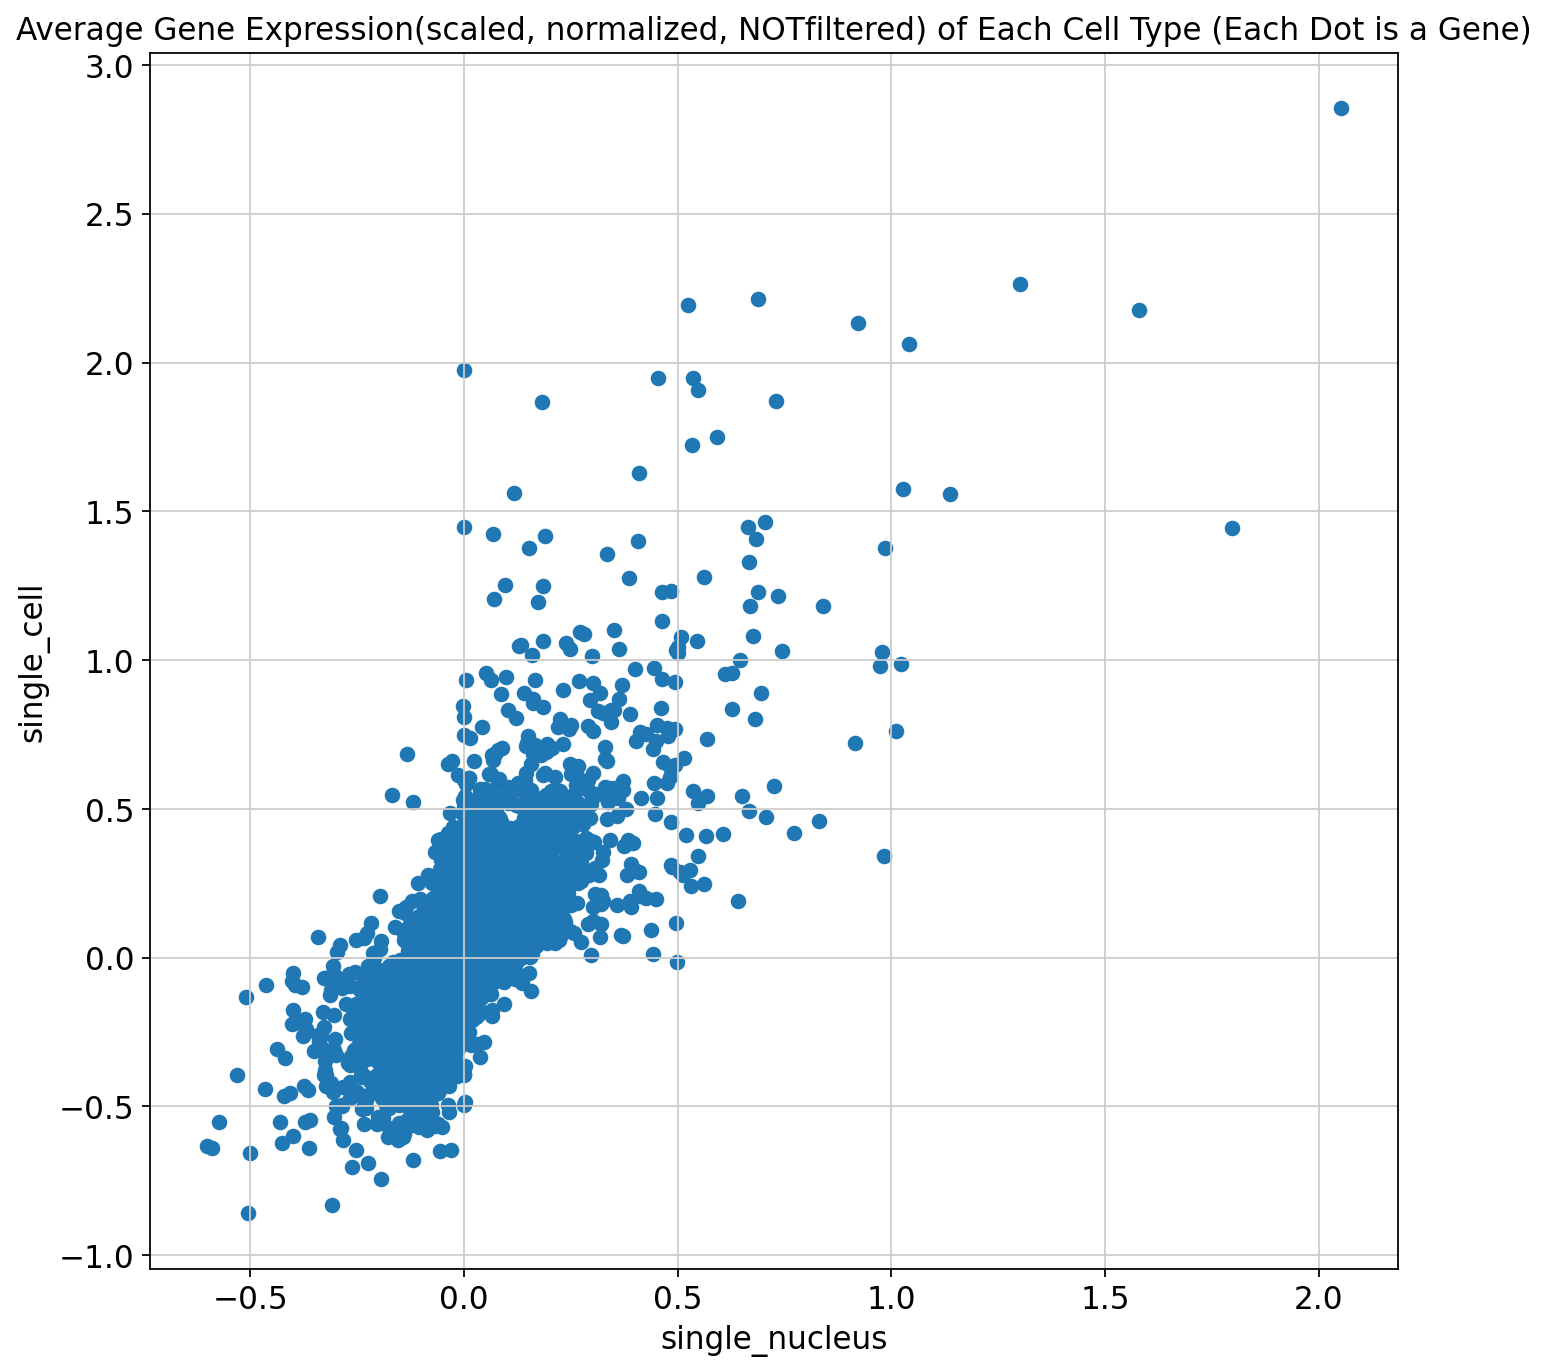

In [ ]:
plt.figure(figsize = [10,10])
plt.scatter(x=av_df["SN"], y = av_df["SC"])
plt.xlabel("single_nucleus")
plt.ylabel("single_cell")
plt.title("Average Gene Expression(scaled, normalized, NOTfiltered) of Each Cell Type (Each Dot is a Gene)")
plt.show()

In [ ]:
av_df_celltype = res_inner.transpose()

In [ ]:
matching_celltypes

['CD_IC', 'CD_PC', 'CNT', 'DCT', 'Endo', 'MC', 'MPH', 'PT', 'Podo', 'aLOH']

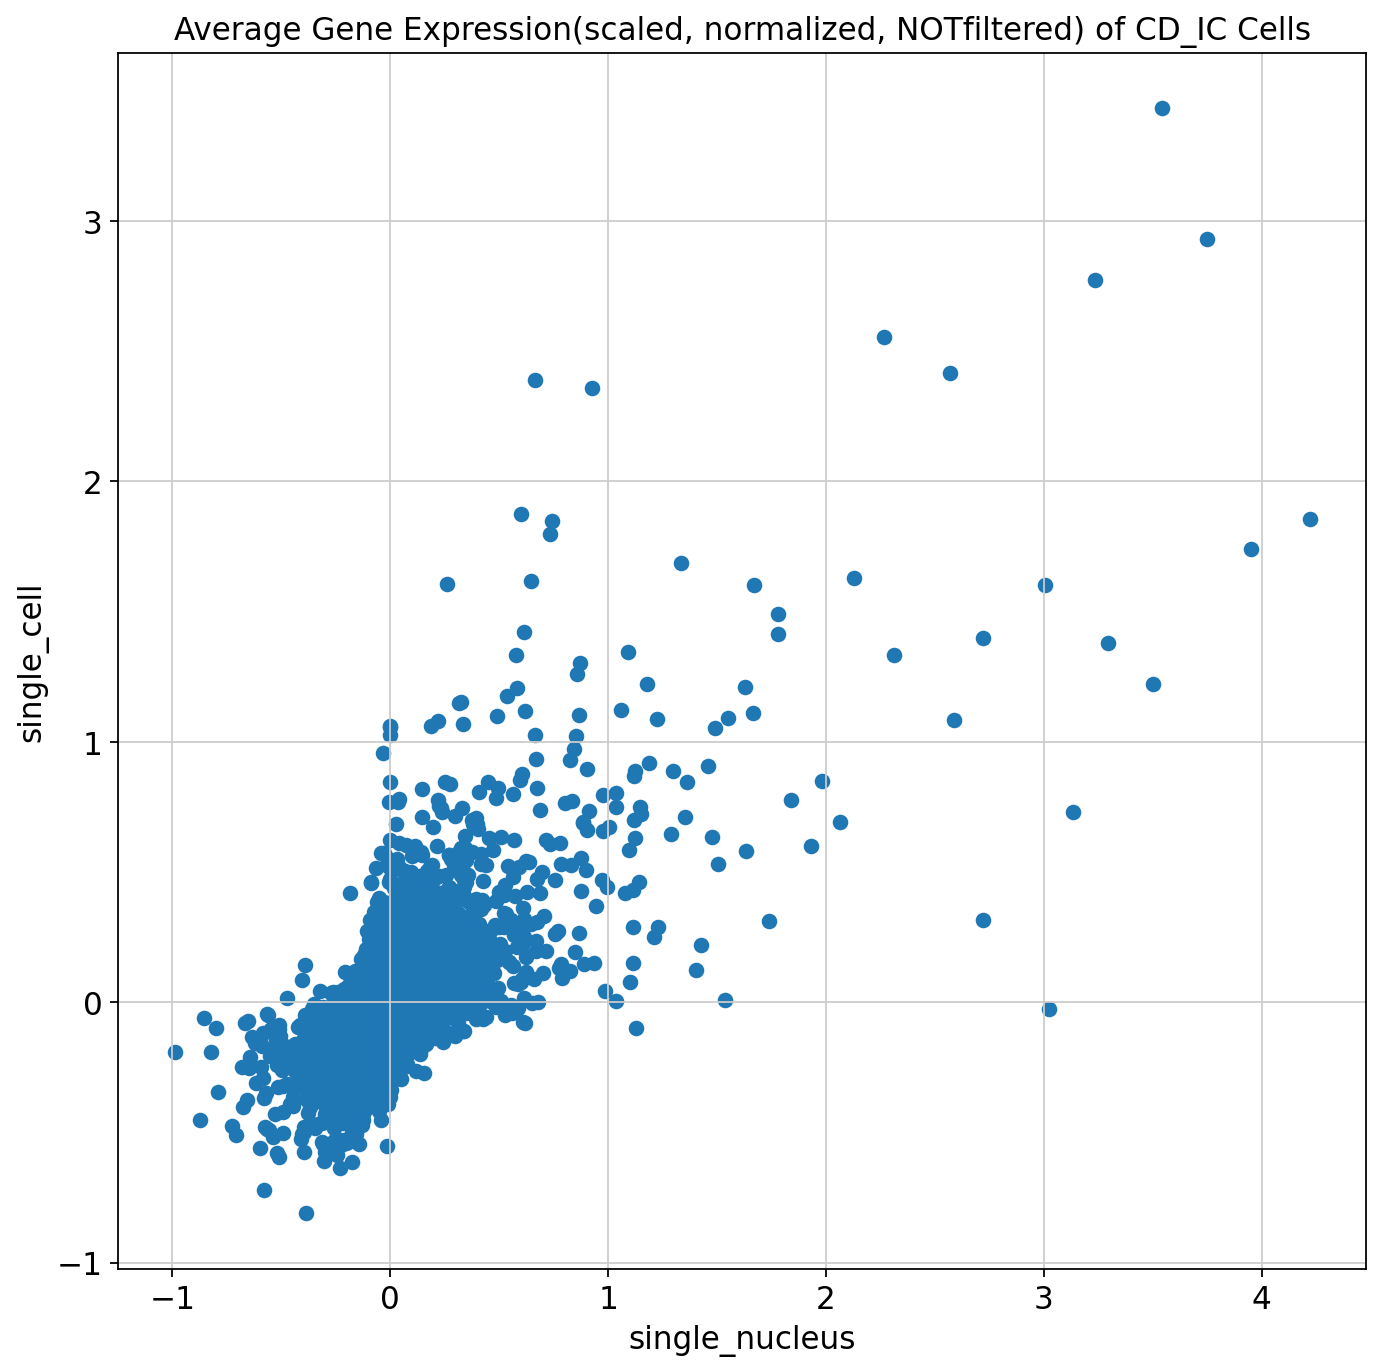

In [ ]:
plt.figure(figsize = [10,10])
plt.scatter(x=av_df_celltype["single_nucleus_CD_IC"], y = av_df_celltype["single_cell_CD_IC"])
plt.xlabel("single_nucleus")
plt.ylabel("single_cell")
plt.title("Average Gene Expression(scaled, normalized, NOTfiltered) of CD_IC Cells")
plt.show()

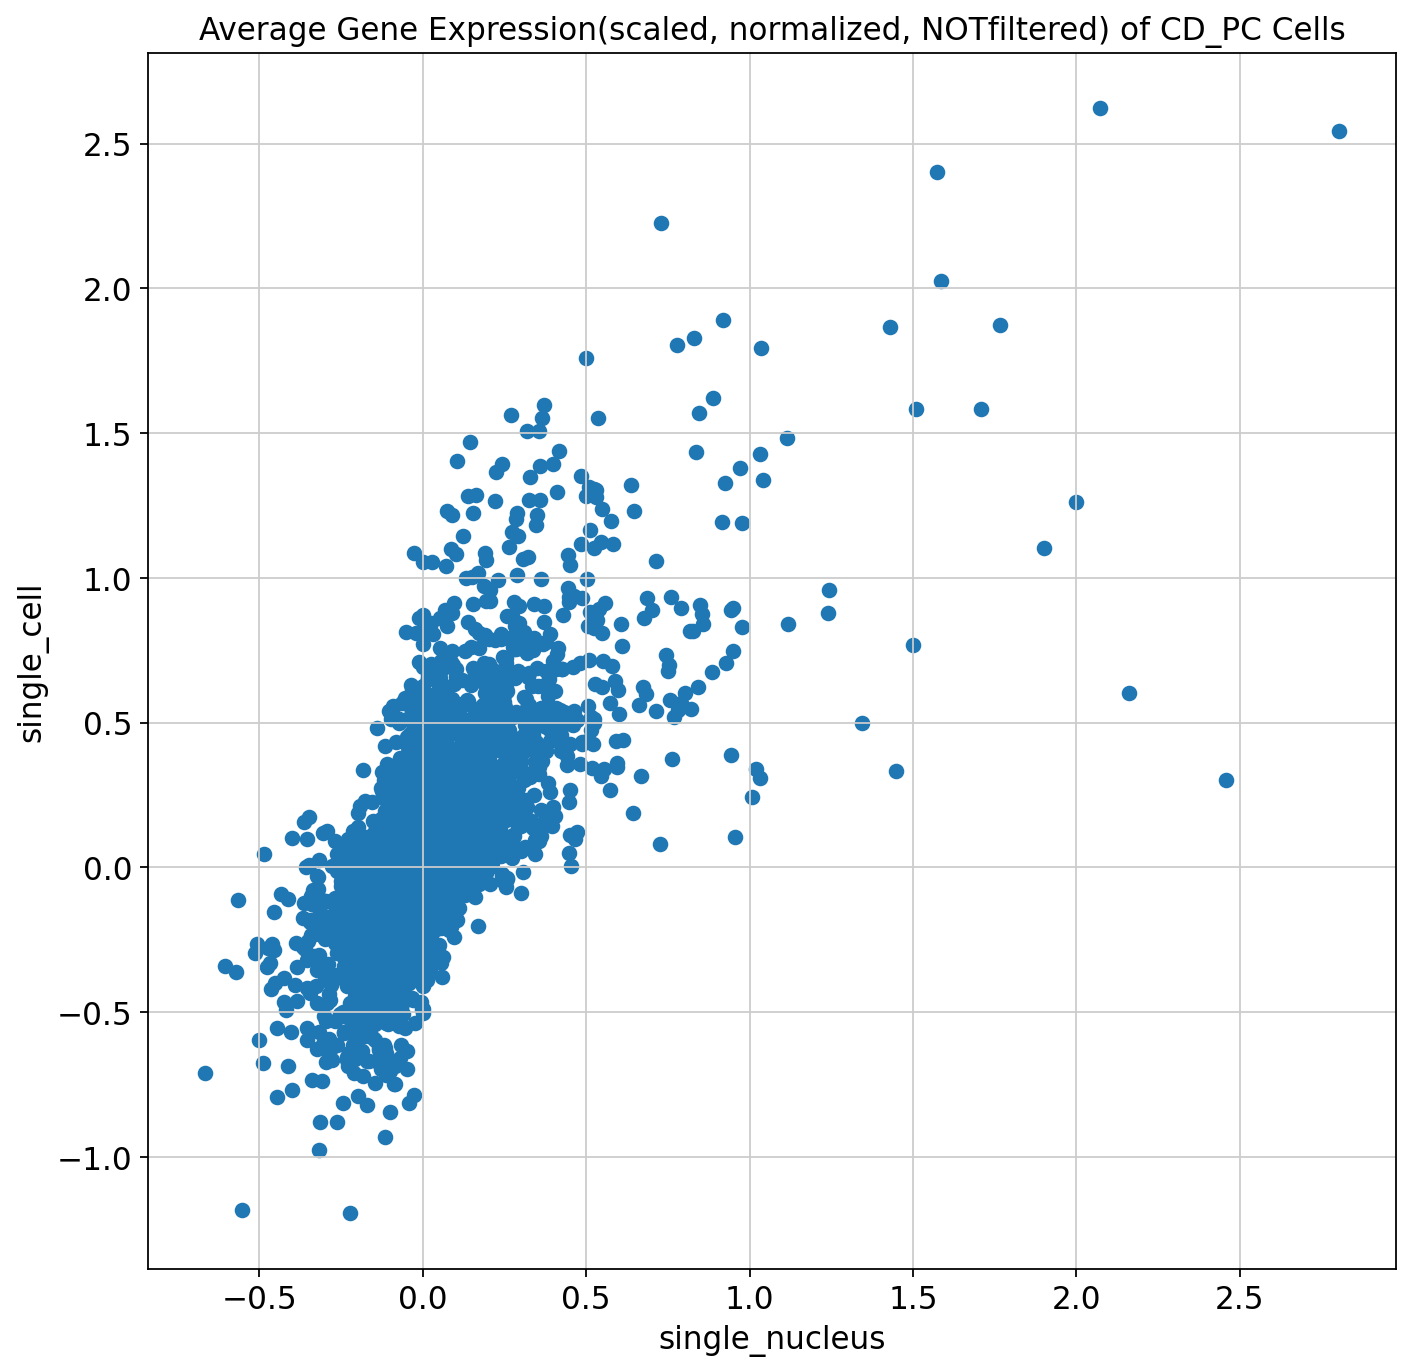

In [ ]:
plt.figure(figsize = [10,10])
plt.scatter(x=av_df_celltype["single_nucleus_CD_PC"], y = av_df_celltype["single_cell_CD_PC"])
plt.xlabel("single_nucleus")
plt.ylabel("single_cell")
plt.title("Average Gene Expression(scaled, normalized, NOTfiltered) of CD_PC Cells")
plt.show()

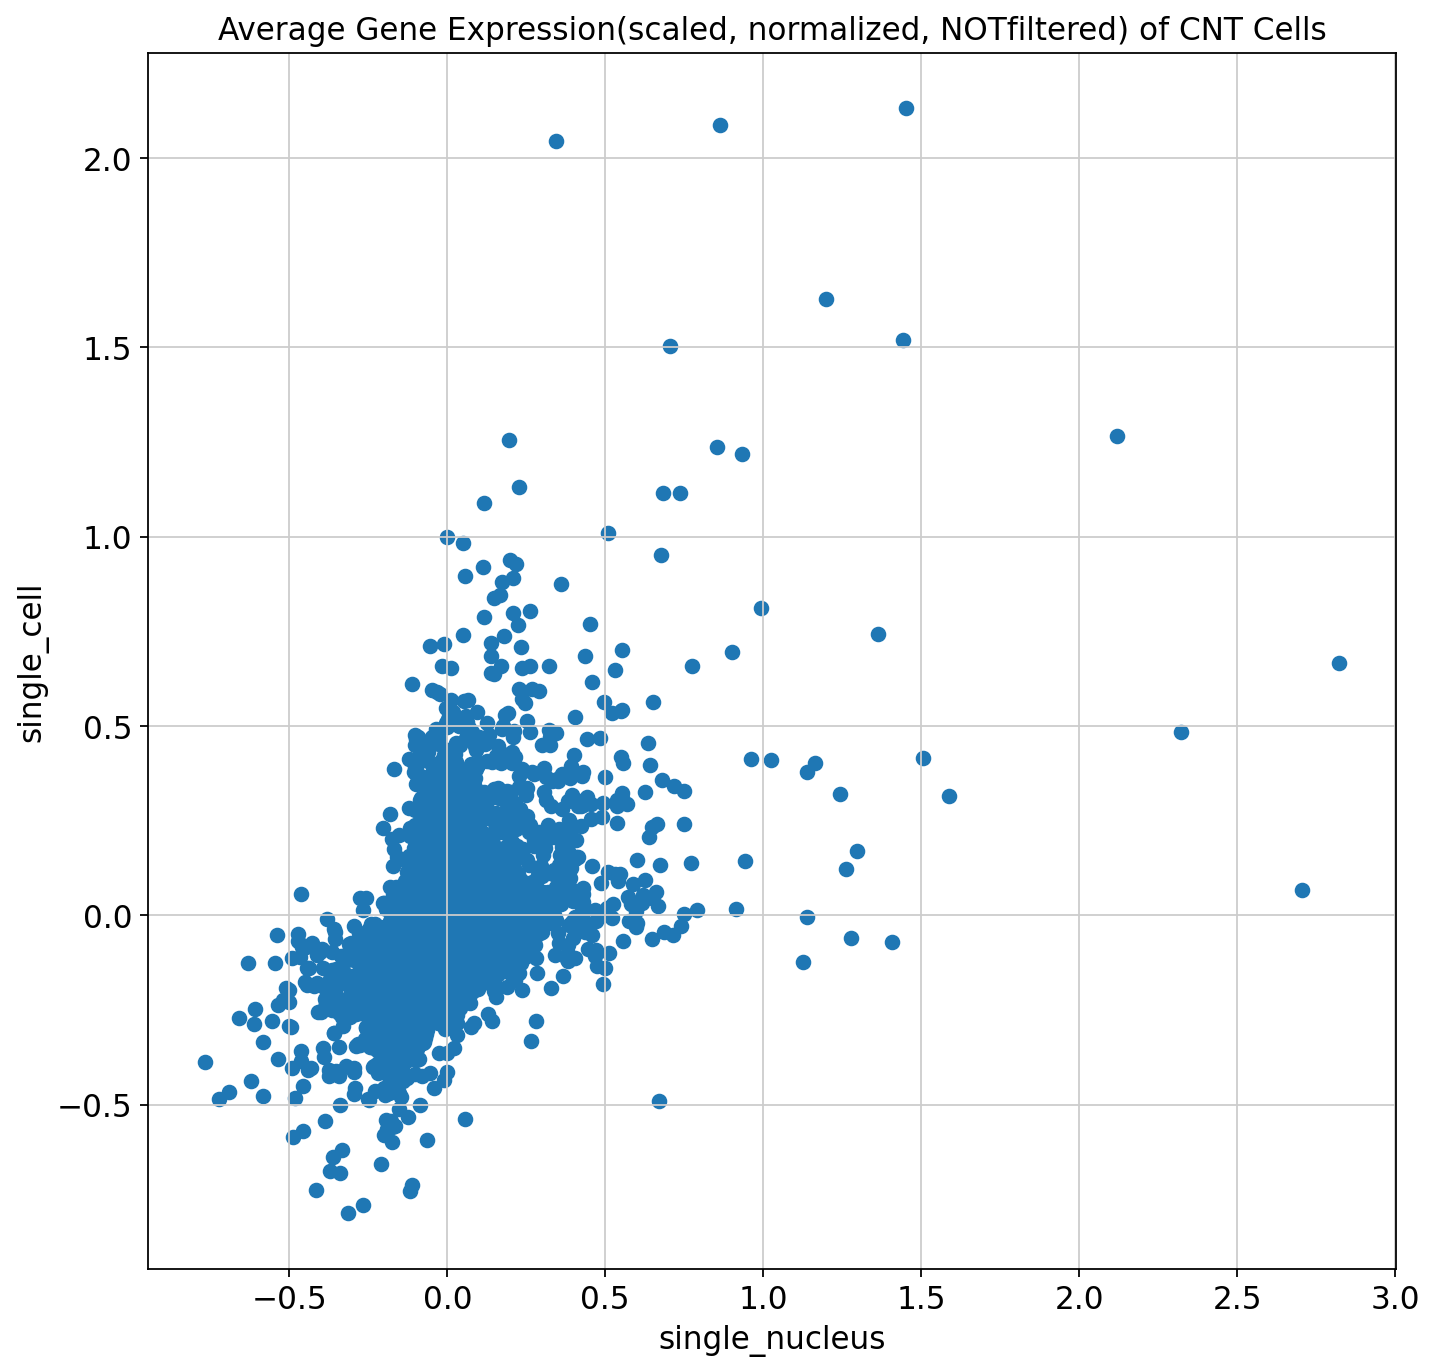

In [ ]:
plt.figure(figsize = [10,10])
plt.scatter(x=av_df_celltype["single_nucleus_CNT"], y = av_df_celltype["single_cell_CNT"])
plt.xlabel("single_nucleus")
plt.ylabel("single_cell")
plt.title("Average Gene Expression(scaled, normalized, NOTfiltered) of CNT Cells")
plt.show()

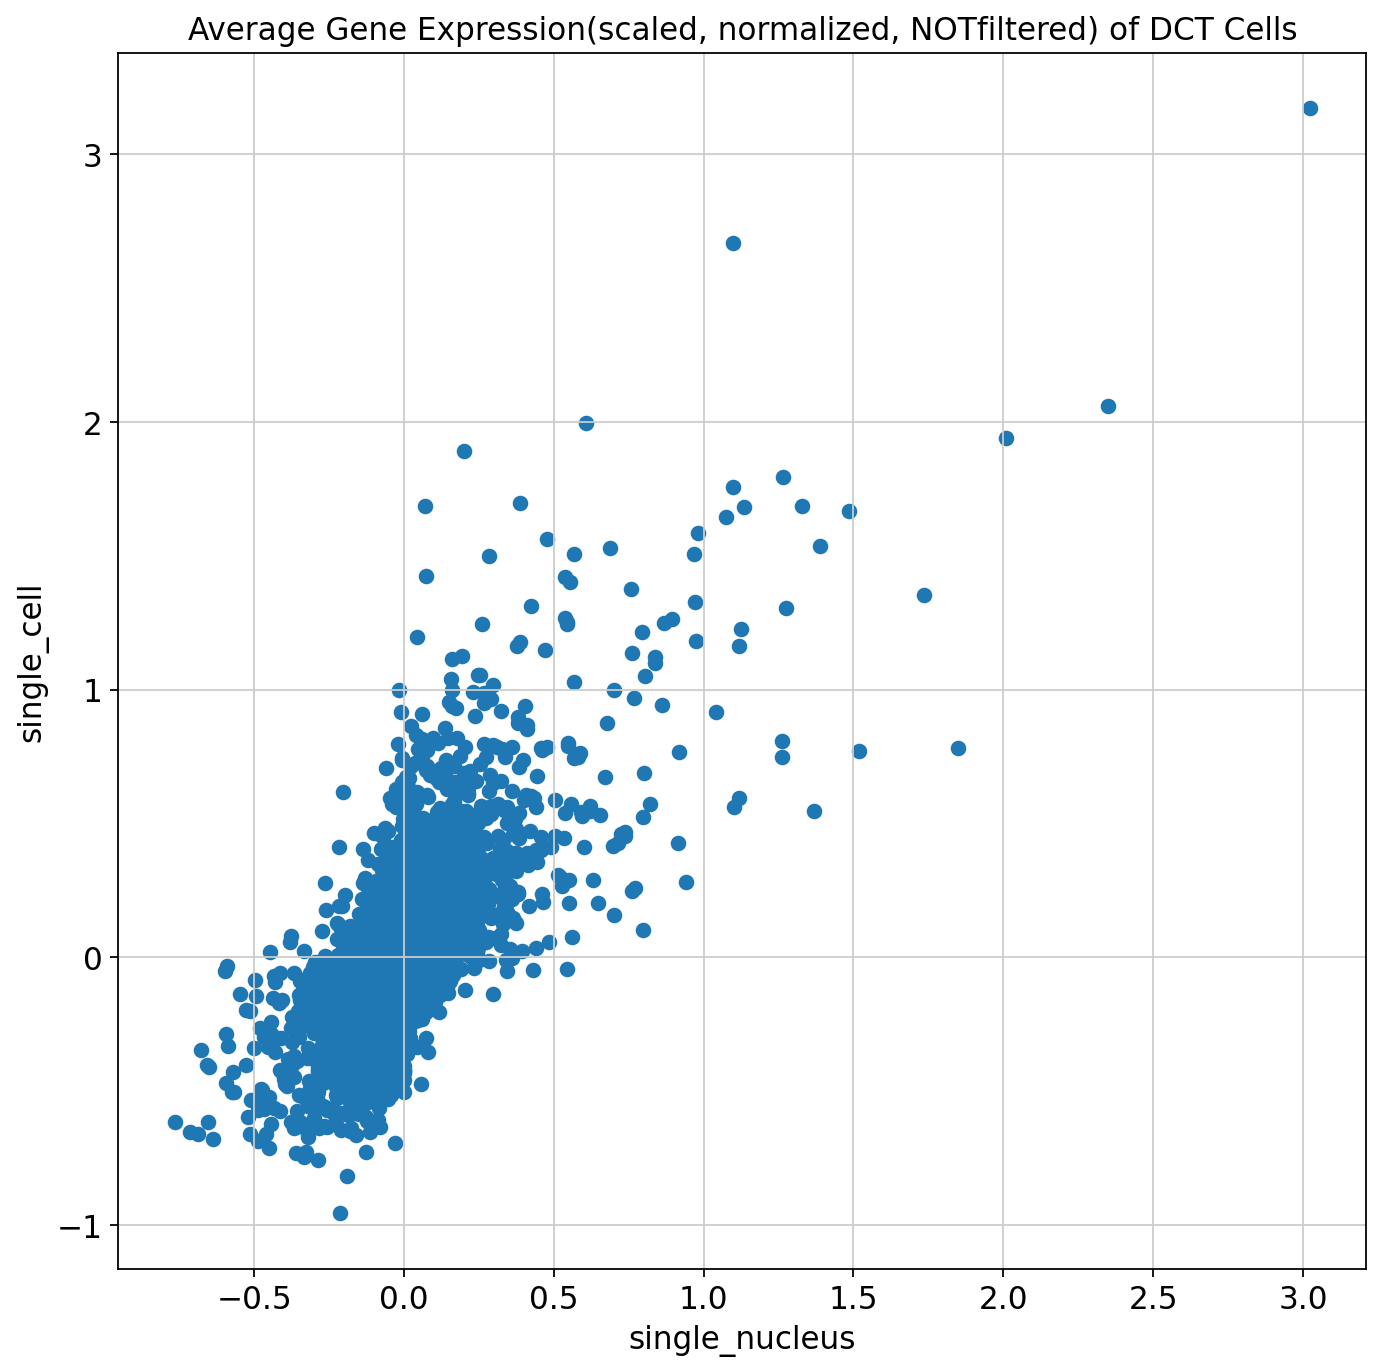

In [ ]:
plt.figure(figsize = [10,10])
plt.scatter(x=av_df_celltype["single_nucleus_DCT"], y = av_df_celltype["single_cell_DCT"])
plt.xlabel("single_nucleus")
plt.ylabel("single_cell")
plt.title("Average Gene Expression(scaled, normalized, NOTfiltered) of DCT Cells")
plt.show()

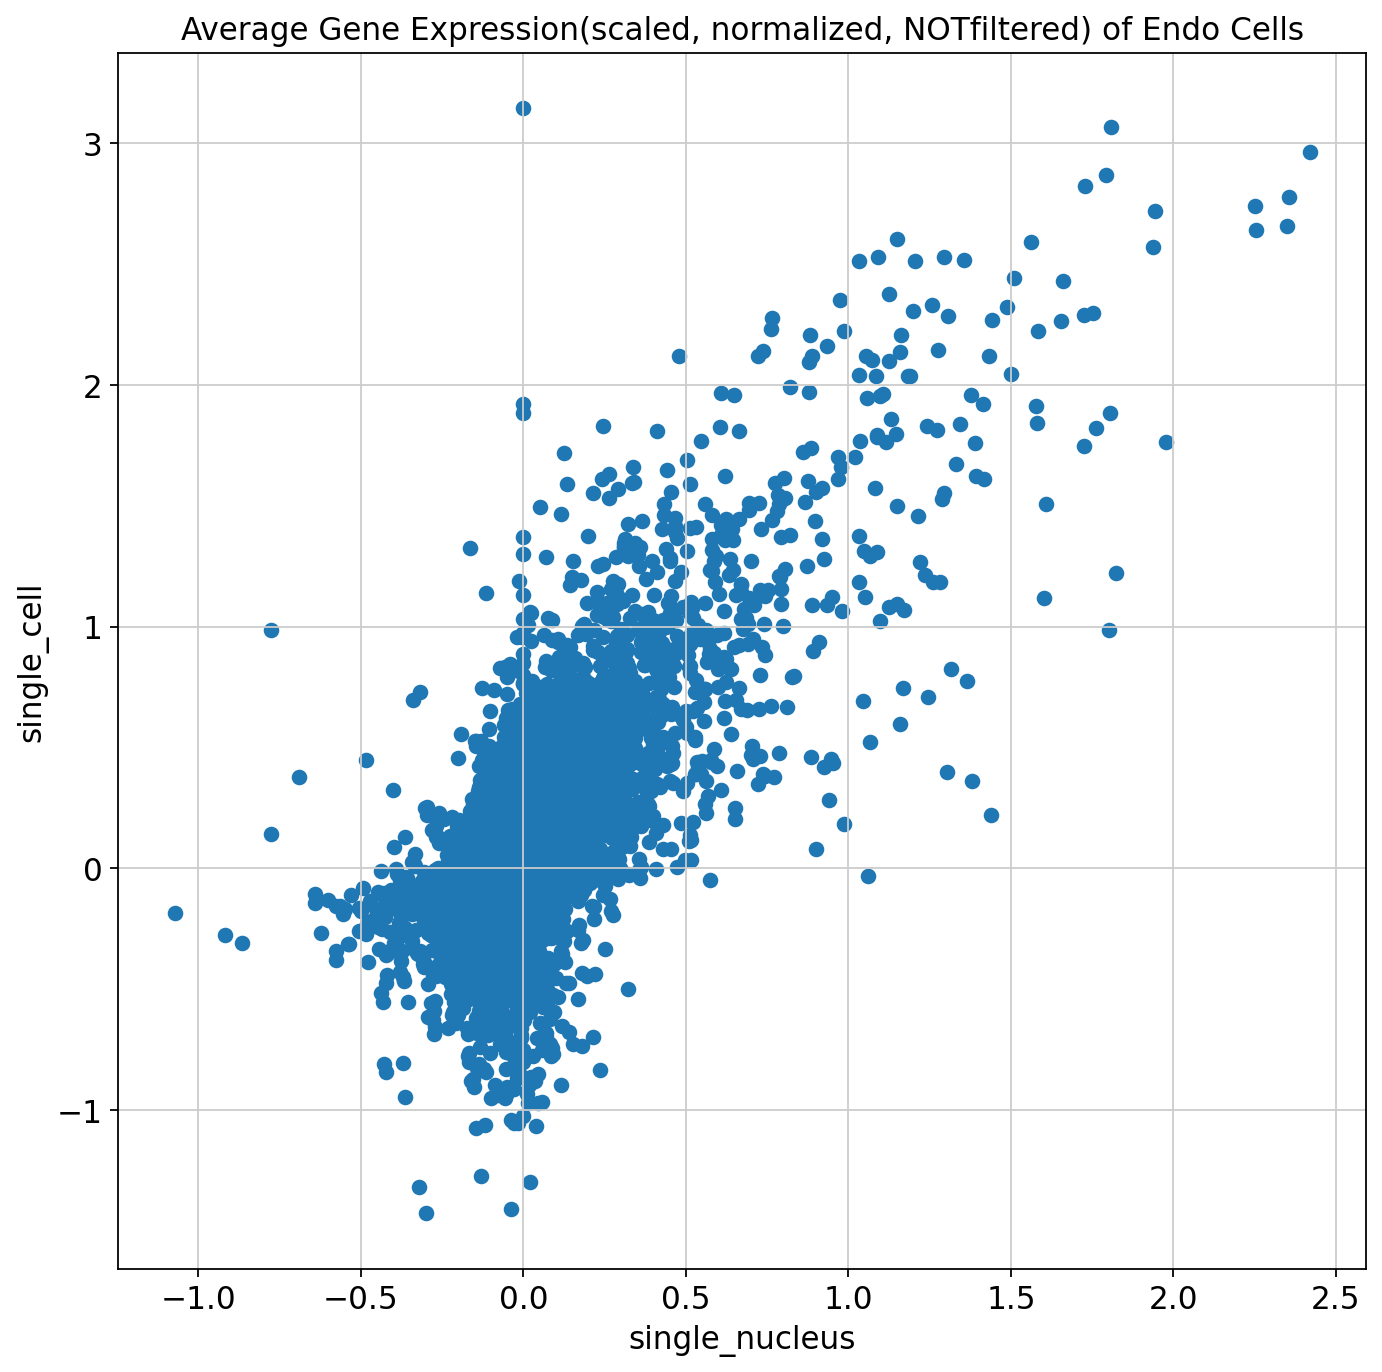

In [ ]:
plt.figure(figsize = [10,10])
plt.scatter(x=av_df_celltype["single_nucleus_Endo"], y = av_df_celltype["single_cell_Endo"])
plt.xlabel("single_nucleus")
plt.ylabel("single_cell")
plt.title("Average Gene Expression(scaled, normalized, NOTfiltered) of Endo Cells")
plt.show()

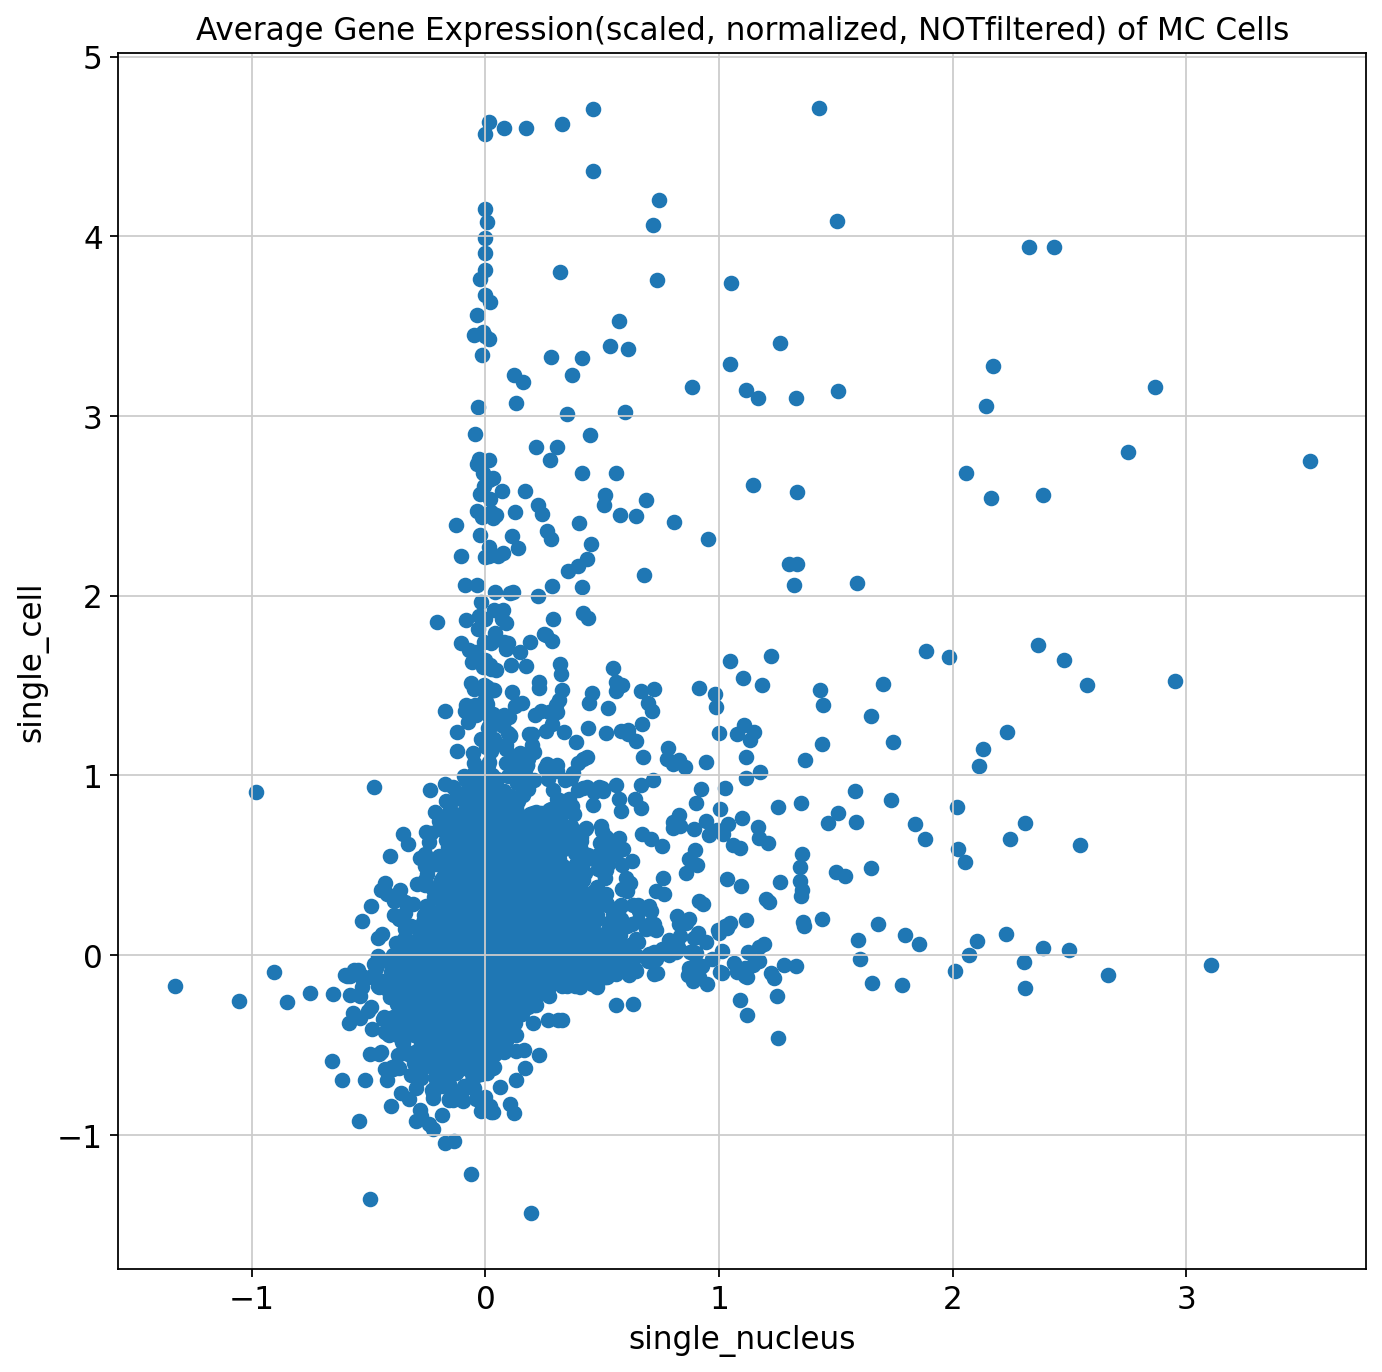

In [ ]:
plt.figure(figsize = [10,10])
plt.scatter(x=av_df_celltype["single_nucleus_MC"], y = av_df_celltype["single_cell_MC"])
plt.xlabel("single_nucleus")
plt.ylabel("single_cell")
plt.title("Average Gene Expression(scaled, normalized, NOTfiltered) of MC Cells")
plt.show()

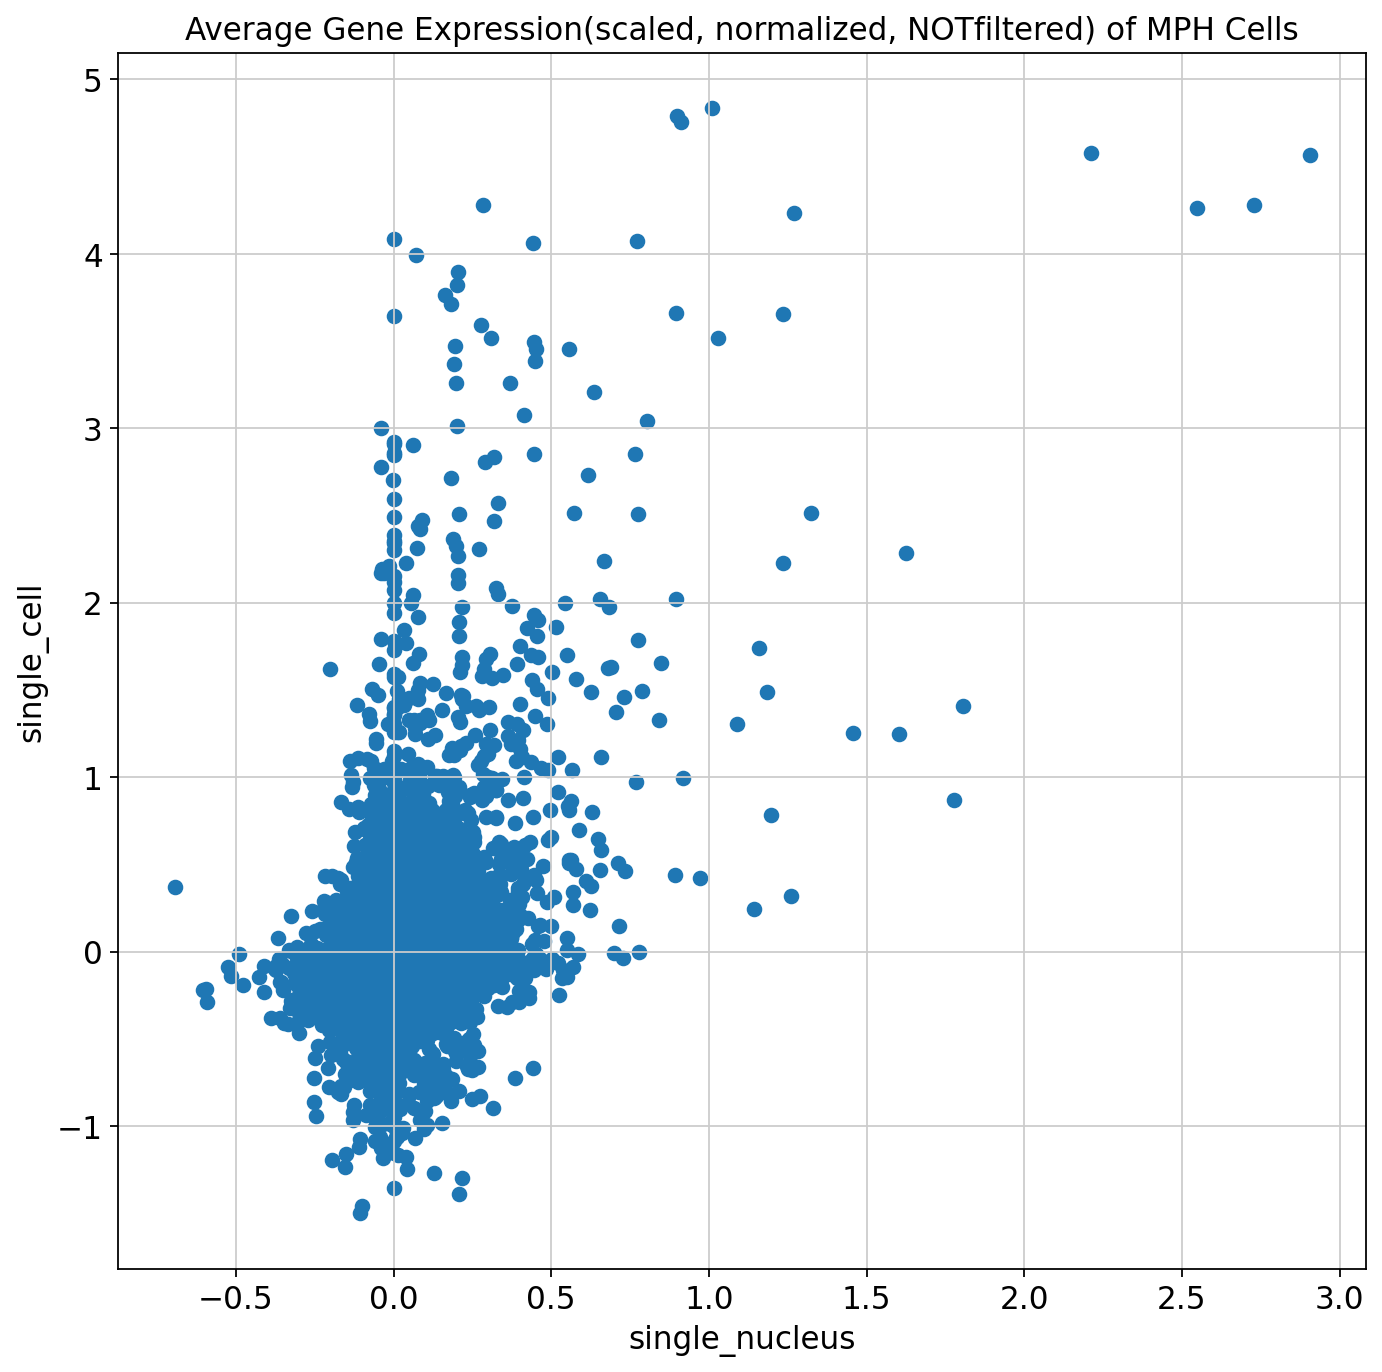

In [ ]:
plt.figure(figsize = [10,10])
plt.scatter(x=av_df_celltype["single_nucleus_MPH"], y = av_df_celltype["single_cell_MPH"])
plt.xlabel("single_nucleus")
plt.ylabel("single_cell")
plt.title("Average Gene Expression(scaled, normalized, NOTfiltered) of MPH Cells")
plt.show()

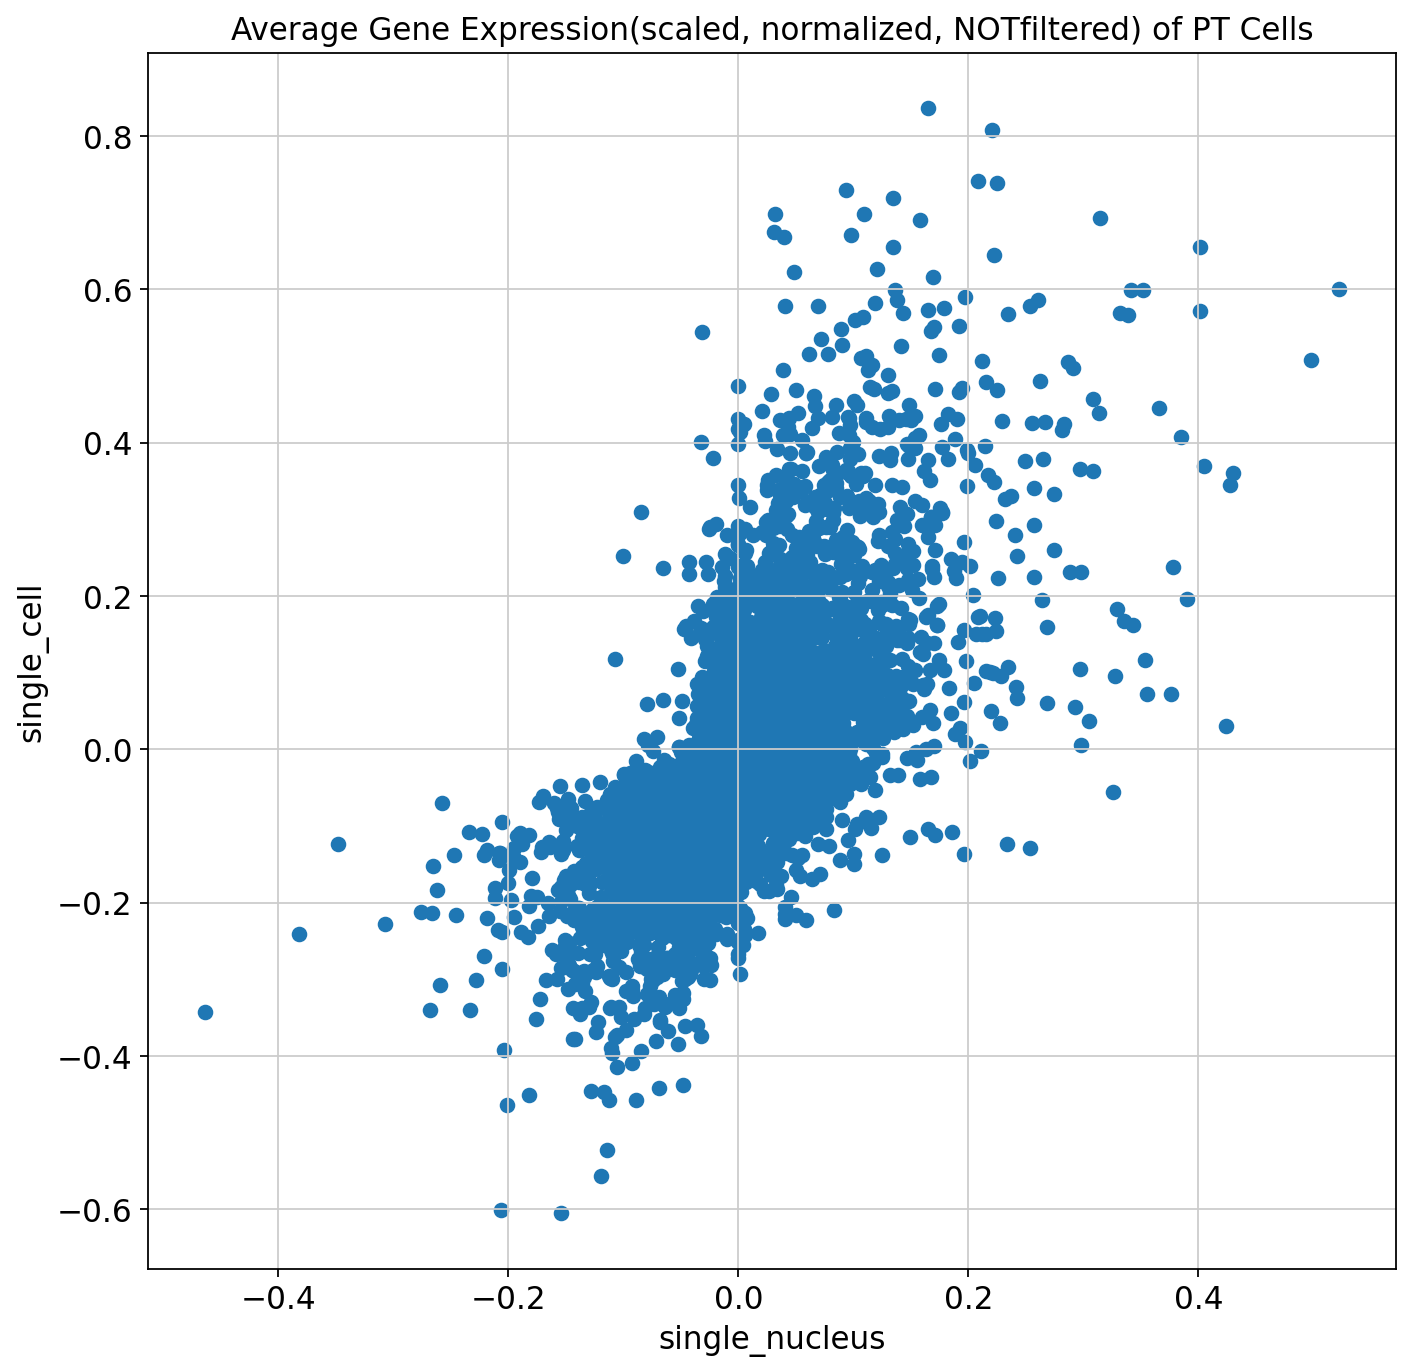

In [ ]:
plt.figure(figsize = [10,10])
plt.scatter(x=av_df_celltype["single_nucleus_PT"], y = av_df_celltype["single_cell_PT"])
plt.xlabel("single_nucleus")
plt.ylabel("single_cell")
plt.title("Average Gene Expression(scaled, normalized, NOTfiltered) of PT Cells")
plt.show()

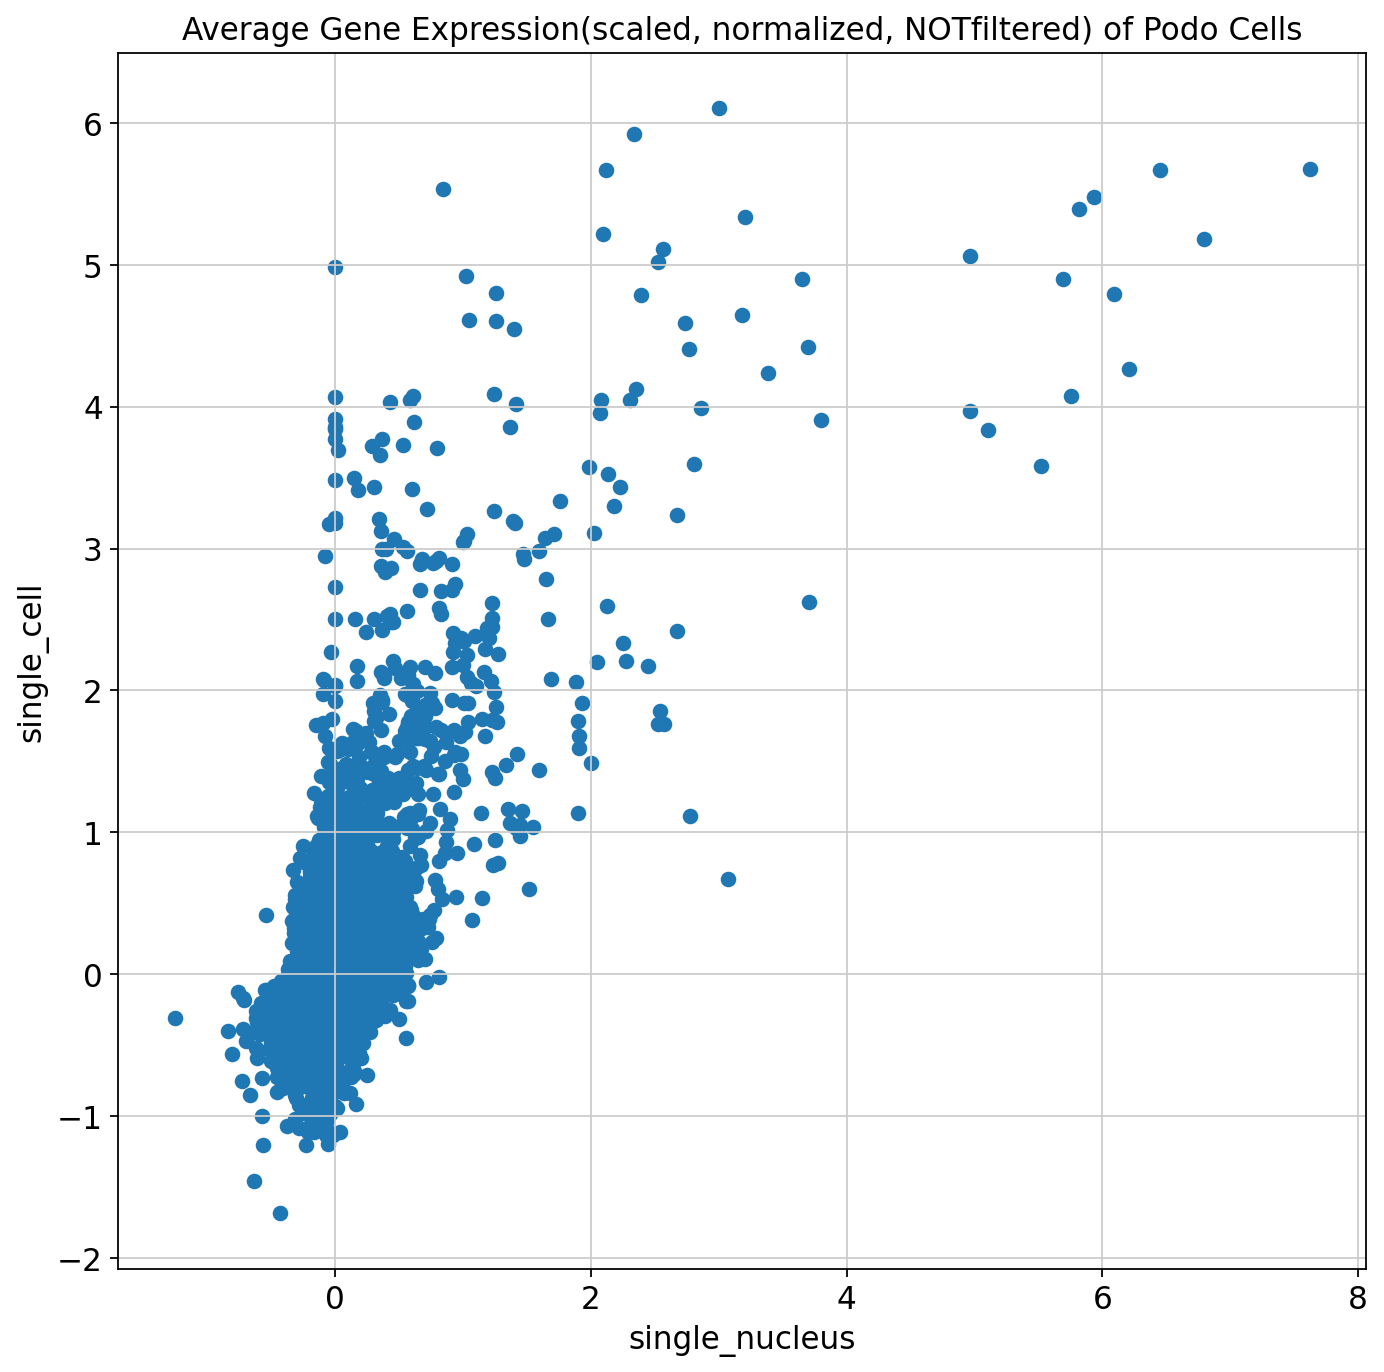

In [ ]:
plt.figure(figsize = [10,10])
plt.scatter(x=av_df_celltype["single_nucleus_Podo"], y = av_df_celltype["single_cell_Podo"])
plt.xlabel("single_nucleus")
plt.ylabel("single_cell")
plt.title("Average Gene Expression(scaled, normalized, NOTfiltered) of Podo Cells")
plt.show()

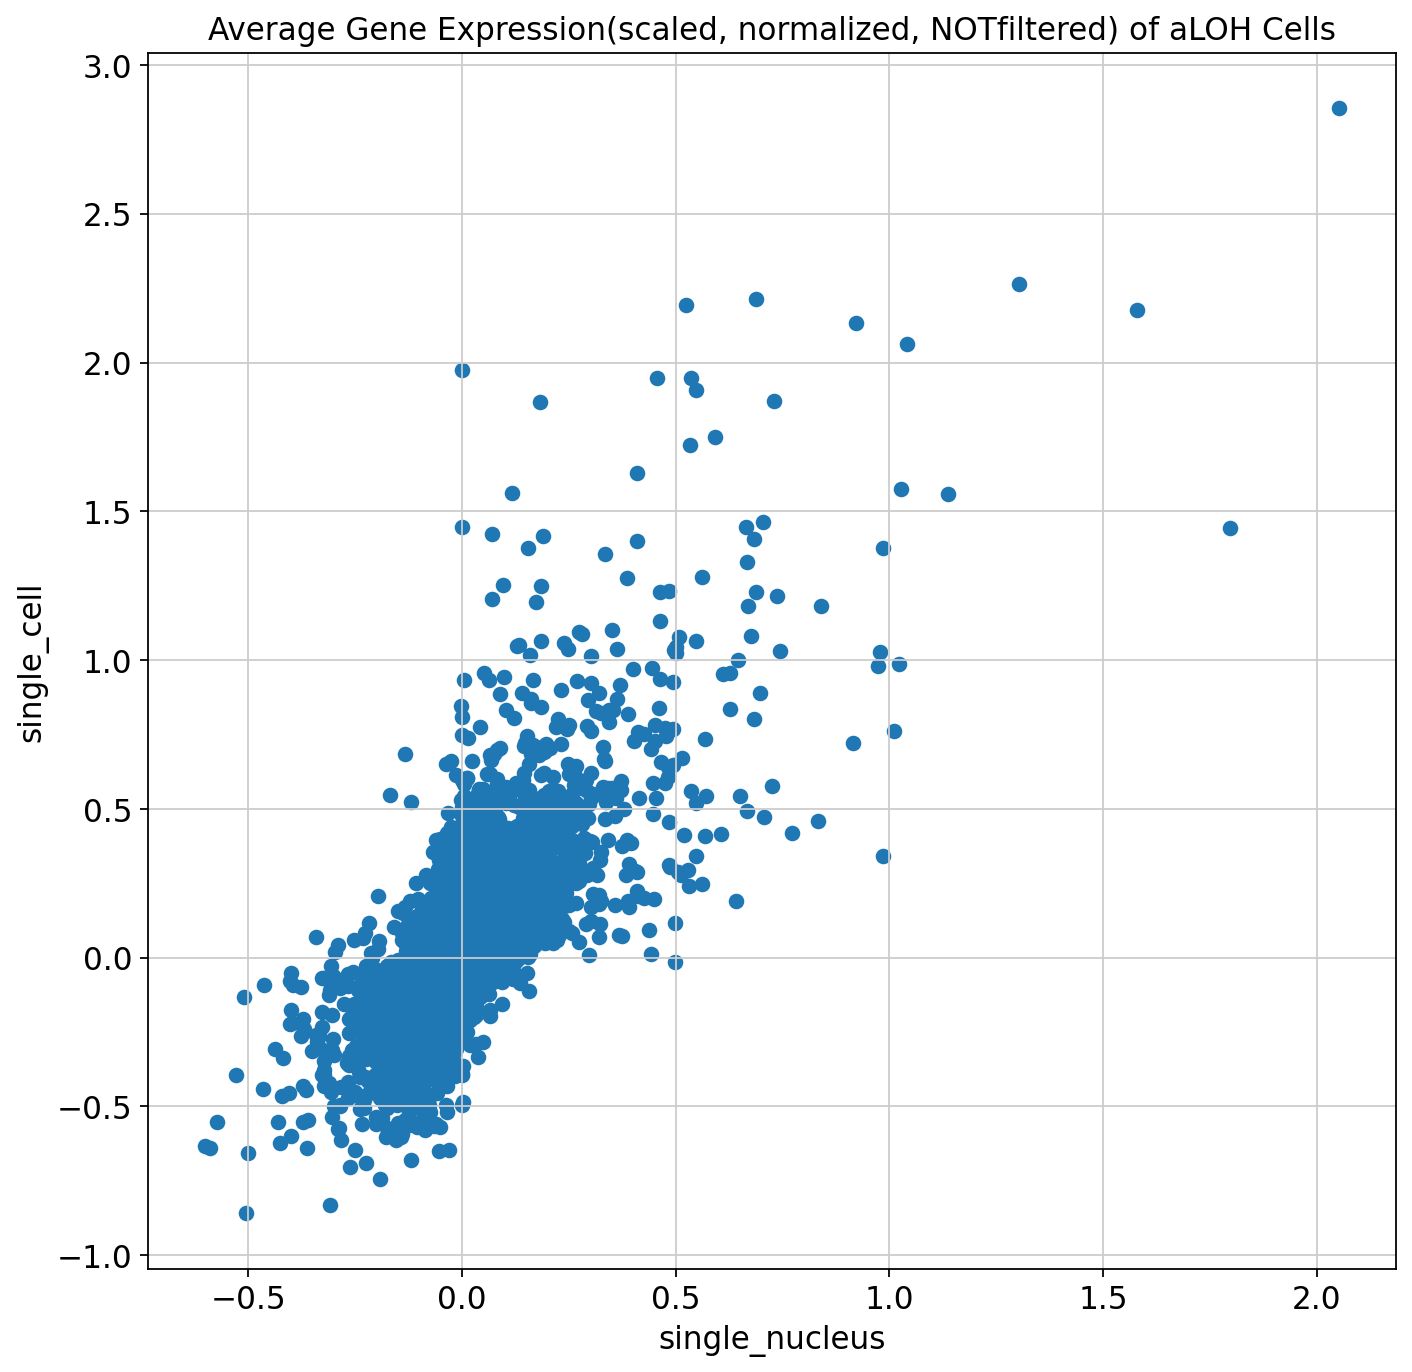

In [ ]:
plt.figure(figsize = [10,10])
plt.scatter(x=av_df_celltype["single_nucleus_aLOH"], y = av_df_celltype["single_cell_aLOH"])
plt.xlabel("single_nucleus")
plt.ylabel("single_cell")
plt.title("Average Gene Expression(scaled, normalized, NOTfiltered) of aLOH Cells")
plt.show()

In [ ]:
#funtion from https://github.com/greenelab/sc_bulk_ood/blob/main/evaluation_experiments/pbmc/pbmc_experiment_perturbation.ipynb
def mean_sqr_error(single1, single2):
  return np.mean((single1 - single2)**2)

In [ ]:
single_df = pd.DataFrame(single_adata_inner.X, columns = single_adata_inner.var_names, index = single_adata_inner.obs['orig_and_celltype'])
single_df

Sox17    Mrpl15    Lypla1     Tcea1   Atp6v1h  \
orig_and_celltype                                                       
single_nucleus_aLOH -0.119930 -0.215292  0.000000 -0.131030 -0.275533   
single_nucleus_aLOH -0.119884 -0.203488  0.000000 -0.143374 -0.273186   
single_nucleus_aLOH -0.113487 -0.220597  0.000000 -0.143025 -0.285673   
single_nucleus_PT   -0.067728 -0.280903  0.000000 -0.204789 -0.362314   
single_nucleus_aLOH -0.103388 -0.233517  0.000000 -0.157058  3.234097   
...                       ...       ...       ...       ...       ...   
single_cell_PT      -0.186533  1.128348  1.437925 -0.455009 -0.504980   
single_cell_CNT     -0.195385 -0.437815 -0.338087  3.731532  3.377913   
single_cell_aLOH    -0.168684 -0.462054 -0.334550 -0.334945 -0.386876   
single_cell_Endo    -0.163634 -0.428987  4.409280 -0.310775 -0.364966   
single_cell_PT      -0.192973 -0.494626 -0.400795 -0.368333 -0.394960   

                       Rb1cc1  4732440D04Rik    Pcmtd1      Rrs1    Adhfe1  \
orig_and_celltype                                                            
single_nucleus_aLOH -0.309843      -0.186883 -0.366973 -0.106677 -0.242896   
single_nucleus_aLOH -0.297500      -0.173300 -0.347077 -0.130660 -0.252486   
single_nucleus_aLOH -0.314782      -0.180998 -0.374202 -0.136884 -0.296341   
single_nucleus_PT   -0.373511      -0.165079 -0.463667 -0.305992 -0.658310   
single_nucleus_aLOH -0.327336      -0.177040 -0.393292 -0.174985 -0.376526   
...                       ...            ...       ...       ...       ...   
single_cell_PT      -0.557445      -0.322141  1.267385 -0.300011 -0.587777   
single_cell_CNT     -0.304322      -0.111358 -0.398939 -0.202562 -0.401125   
single_cell_aLOH    -0.316687      -0.123308 -0.431814 -0.216972 -0.390838   
single_cell_Endo    -0.268598      -0.083687 -0.402034 -0.200932 -0.350406   
single_cell_PT      -0.378595      -0.173196 -0.454130 -0.231088 -0.456031   

                     ...    Apold1     Kcnn4      Otoa     Klkb1   Tmem221  \
orig_and_celltype    ...                                                     
single_nucleus_aLOH  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
single_nucleus_aLOH  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
single_nucleus_aLOH  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
single_nucleus_PT    ...  0.000000  0.000000  0.000000  0.000000  0.000000   
single_nucleus_aLOH  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
...                  ...       ...       ...       ...       ...       ...   
single_cell_PT       ... -0.055847 -0.071738 -0.050925 -0.057528 -0.069030   
single_cell_CNT      ... -0.054249 -0.055330 -0.032695 -0.028033 -0.037393   
single_cell_aLOH     ... -0.055262 -0.041235 -0.028009 -0.034193 -0.053830   
single_cell_Endo     ... -0.055198 -0.034301 -0.023117 -0.029798 -0.051635   
single_cell_PT       ... -0.054711 -0.060250 -0.038083 -0.036654 -0.046571   

                         Rec8    Med9os    Apol9a    Apol7c      Btla  
orig_and_celltype                                                      
single_nucleus_aLOH  0.000000  0.000000  0.000000  0.000000  0.000000  
single_nucleus_aLOH  0.000000  0.000000  0.000000  0.000000  0.000000  
single_nucleus_aLOH  0.000000  0.000000  0.000000  0.000000  0.000000  
single_nucleus_PT    0.000000  0.000000  0.000000  0.000000  0.000000  
single_nucleus_aLOH  0.000000  0.000000  0.000000  0.000000  0.000000  
...                       ...       ...       ...       ...       ...  
single_cell_PT      -0.031479 -0.092843 -0.067118 -0.070913 -0.055148  
single_cell_CNT     -0.058613 -0.049954 -0.049590 -0.052485 -0.005424  
single_cell_aLOH    -0.075735 -0.049500 -0.034874 -0.050308  0.004770  
single_cell_Endo    -0.085617 -0.040699 -0.027554 -0.046019  0.017451  
single_cell_PT      -0.050521 -0.062557 -0.054843 -0.057914 -0.020104  

[13201 rows x 13350 columns]

In [ ]:
#Getting a dataframe with all the mean square errors of each cell type and gene pair average expression.
for gene in single_df.columns:
    for cell in matching_celltypes:
        #mean of all the expression of celltype in gene in sc and sn
        sc_val = np.mean(single_df.loc[f"single_cell_{cell}"][gene])
        sn_val = np.mean(single_df.loc[f"single_nucleus_{cell}"][gene])
        #adding mse to another dataframe
        mse_df.loc[cell][gene] = mean_sqr_error(sc_val, sn_val)
mse_df

KeyboardInterrupt: 

In [ ]:
mse_df = mse_df.astype('float')
mse_df = mse_df.transpose()

In [ ]:
#Saving mse df
pickle.dump(mse_df, open( f"{processed_path}mse_snsc_df_scaled_notfiltered.pkl", "wb" ) )

In [ ]:
av_df_celltype = res_inner.transpose()

In [ ]:
av_df_celltype

single_cell_CD_IC single_cell_CD_PC single_cell_CD_Trans  \
0610007P14Rik          -0.01709          0.144851            -0.360056   
0610009B22Rik           0.09729          -0.09161            -0.206036   
0610009L18Rik         -0.101456          0.105742              0.93643   
0610009O20Rik          0.060088          0.072429             1.432581   
0610010F05Rik         -0.022538          0.026151            -0.171225   
...                         ...               ...                  ...   
Zyg11b                 0.129273           0.02348             1.360405   
Zyx                   -0.093145         -0.118113            -0.208304   
Zzef1                 -0.004219          0.097172            -0.274471   
Zzz3                   0.110975          0.056274             0.363149   
l7Rn6                 -0.087694         -0.043138            -0.378458   

              single_cell_CNT single_cell_DCT single_cell_Endo  \
0610007P14Rik       -0.102943       -0.061861          0.09471   
0610009B22Rik        0.124871        0.091742        -0.149842   
0610009L18Rik        0.176535        0.049945        -0.156689   
0610009O20Rik       -0.050969        0.030005         0.239113   
0610010F05Rik        0.157833       -0.013869         0.059784   
...                       ...             ...              ...   
Zyg11b              -0.013896        0.116732         0.007486   
Zyx                 -0.131396       -0.097893         0.088527   
Zzef1               -0.134628       -0.014545         0.201111   
Zzz3                -0.003518       -0.000793         0.029026   
l7Rn6                0.044726       -0.028291         0.039276   

              single_cell_Fib single_cell_MC single_cell_MPH single_cell_NK  \
0610007P14Rik        0.159107      -0.031672       -0.071985       0.339084   
0610009B22Rik       -0.495742       0.070279       -0.294058      -0.434171   
0610009L18Rik       -0.286291       0.296943        -0.13167      -0.189705   
0610009O20Rik        0.019708       0.065036       -0.200023      -0.207813   
0610010F05Rik       -0.007351      -0.107066       -0.078784       -0.15147   
...                       ...            ...             ...            ...   
Zyg11b              -0.018503       0.109355       -0.065522       0.288113   
Zyx                  1.177976       0.890627        0.039215       0.801379   
Zzef1               -0.224073       0.080645        0.117303       0.162978   
Zzz3                  0.02433        0.16701       -0.126309         0.2162   
l7Rn6               -0.098437       0.214565       -0.090384       0.004577   

               ... single_nucleus_CD_PC single_nucleus_CNT single_nucleus_DCT  \
0610007P14Rik  ...            -0.026208           0.004235          -0.081638   
0610009B22Rik  ...            -0.022325          -0.023184          -0.066299   
0610009L18Rik  ...             0.101706          -0.055296           -0.02242   
0610009O20Rik  ...            -0.017859          -0.020096           0.070188   
0610010F05Rik  ...             0.099863          -0.013877           -0.00599   
...            ...                  ...                ...                ...   
Zyg11b         ...             -0.06271           0.069564           0.010248   
Zyx            ...            -0.006956          -0.078602          -0.035779   
Zzef1          ...             0.003839           0.032171          -0.096701   
Zzz3           ...            -0.052392           0.095982           -0.05385   
l7Rn6          ...             0.017201          -0.076293           0.025415   

              single_nucleus_Endo single_nucleus_MC single_nucleus_MPH  \
0610007P14Rik            0.019549          0.060934          -0.163455   
0610009B22Rik            0.096894         -0.009722          -0.139816   
0610009L18Rik            -0.05681          -0.01482          -0.015212   
0610009O20Rik            0.029858          -0.01556           0.179475   
0610010F05Rik           -0.023381       

In [ ]:
#Getting a dataframe with all the mean square errors of each cell type and gene pair average expression.
df = pd.DataFrame(columns =["SC", "SN"], index = res_inner.columns)
for cell in matching_celltypes:
        #mean of all the expression of celltype in gene in sc and sn
    sc_val = av_df_celltype[f"single_cell_{cell}"]
    sn_val = av_df_celltype[f"single_nucleus_{cell}"]
    corr = pearsonr(sc_val, sn_val)[0]
    pearson_df_snsc[cell] = corr


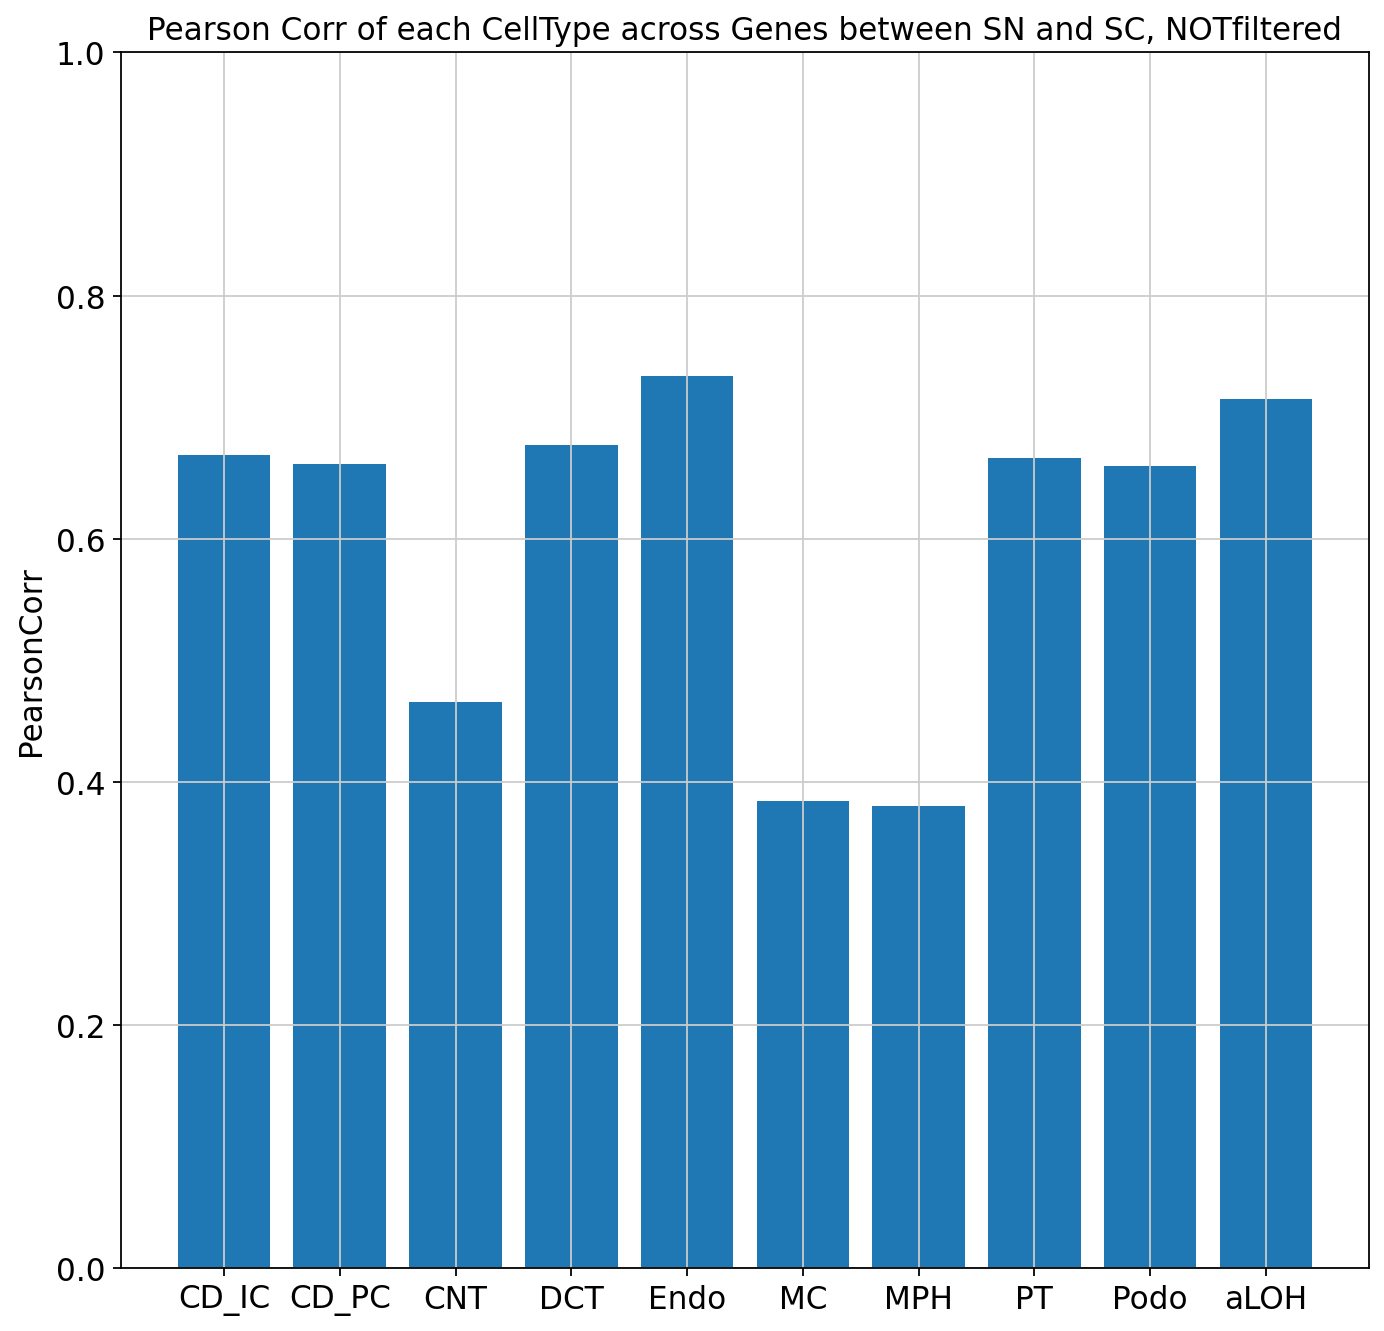

In [ ]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
titles = pearson_df_snsc.columns
counts = pearson_df_snsc.values[0]
bar_labels = pearson_df_snsc.columns

ax.bar(titles, counts, label=bar_labels)
ax.set_ylim([0,1])
ax.set_ylabel('PearsonCorr')
ax.set_title('Pearson Corr of each CellType across Genes between SN and SC, NOTfiltered')

plt.show()

KeyError: "None of [Index(['CD_IC', 'CD_PC', 'CNT', 'DCT', 'Endo', 'MC', 'MPH', 'PT', 'Podo',\n       'aLOH'],\n      dtype='object')] are in the [columns]"

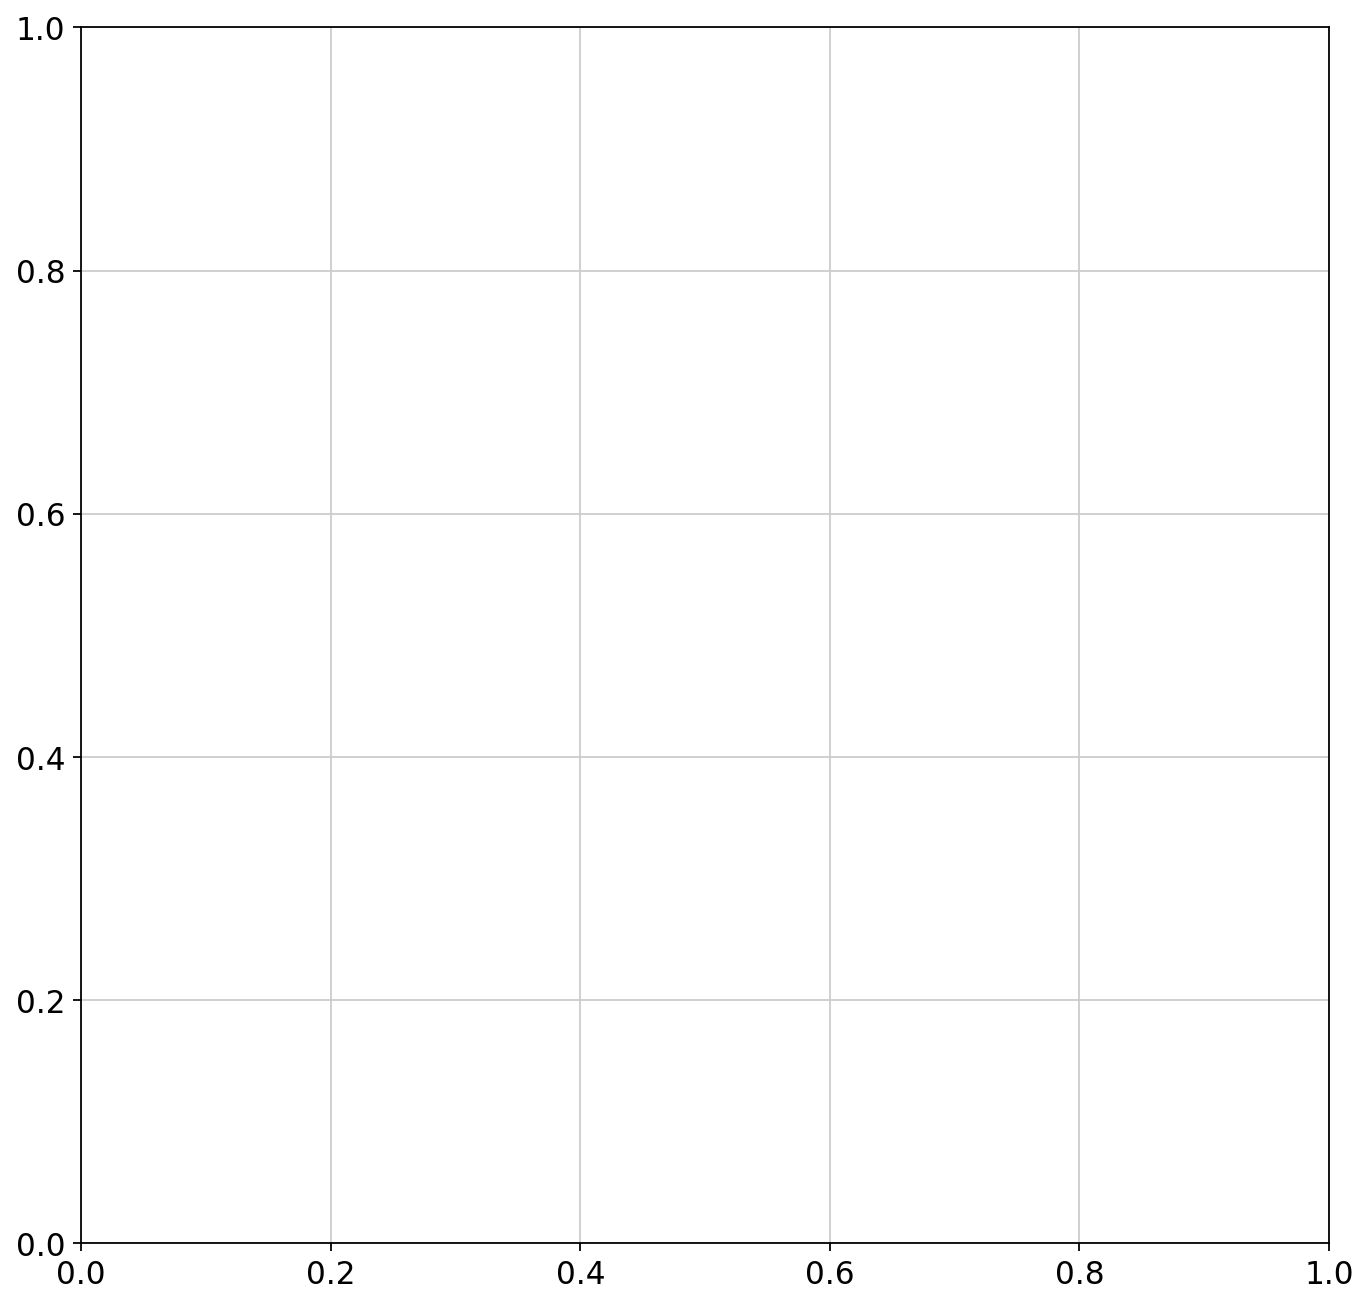

In [ ]:
plt.figure(figsize= [10,10])
ax = mse_df.boxplot(column = ['CD_IC', 'CD_PC', 'CNT', 'DCT', 'Endo', 'MC', 'MPH', 'PT', 'Podo', 'aLOH'])
ax.set_ylim([0,25])
plt.title('MSE of Average SN vs. Average SC per Common Gene, NOTfiltered')

Tryign linear regression model with the first cell type:

In [ ]:
#Code based from https://github.com/scverse/anndata/issues/73 falexwolf commented on Oct 20, 2018
#trimming down the bulk data to contain only genes available in common_genes SN and SC
common_gene_indicator_bulk = np.in1d(bulk_adata.var_names, common_genes_wbulk)
bulk_adata = bulk_adata[:, common_gene_indicator_bulk]
bulk_adata

View of AnnData object with n_obs × n_vars = 1 × 13334
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

In [ ]:
bulk_adata_df = pd.DataFrame(bulk_adata.X, columns=bulk_adata.var_names)
#reordering columsn so they match    
bulk_adata_df= bulk_adata_df.reindex(sorted(bulk_adata_df.columns), axis=1)
bulk_adata_df

0610007P14Rik  0610009B22Rik  0610009L18Rik  0610009O20Rik  0610010F05Rik  \
0       0.273308       0.244163       0.026483       0.585307       0.181677   

   0610010K14Rik  0610011F06Rik  0610012G03Rik  0610025J13Rik  0610030E20Rik  \
0       0.020707       0.924851       0.423421       0.007251       0.421036   

   ...     Zufsp      Zw10     Zwint      Zxdb      Zxdc    Zyg11b       Zyx  \
0  ...  0.102377  0.236293  0.600143  0.067278  0.270189  0.672118  0.407813   

      Zzef1      Zzz3     l7Rn6  
0  0.618199  0.496625  0.211569  

[1 rows x 13334 columns]

In [ ]:
bulk_adata = sc.AnnData(bulk_adata_df)
bulk_adata.var_names[100]

/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


'1810009A15Rik'

In [ ]:
#trimming down the sn and sc data  to contain only genes available in bulk as well.
sn_adata = sn_adata[:, common_genes_wbulk]
sc_adata = sc_adata[:, common_genes_wbulk]

In [ ]:
av_per_gene_sn = pd.DataFrame(columns=sn_adata.var_names, index = [1])
av_per_gene_sc = pd.DataFrame(columns=sn_adata.var_names, index = [1])

In [ ]:
for gene in sn_adata.var_names:
    sum_per_gene = 0 
    for cell in matching_celltypes: 
        sum_per_gene = sum_per_gene + res_inner.loc[f"single_nucleus_{cell}"][gene] 
    av_per_gene_sn[gene] = sum_per_gene / len(matching_celltypes)
av_per_gene_sn    

NameError: name 'av_per_gene_sn' is not defined

In [ ]:
for gene in sc_adata.var_names:
    sum_per_gene = 0 
    for cell in matching_celltypes: 
        sum_per_gene = sum_per_gene + res_inner.loc[f"single_cell_{cell}"][gene] 
    av_per_gene_sc[gene] = sum_per_gene / len(matching_celltypes)
av_per_gene_sc   

0610007P14Rik  0610009B22Rik  0610009L18Rik  0610009O20Rik  0610010F05Rik  \
1      -0.019389      -0.026745       0.047236       0.054225      -0.005787   

   0610010K14Rik  0610011F06Rik  0610012G03Rik  0610025J13Rik  0610030E20Rik  \
1       0.003652      -0.361505      -0.015387      -0.023574       0.067709   

   ...     Zufsp      Zw10     Zwint      Zxdb     Zxdc    Zyg11b       Zyx  \
1  ...  0.054904 -0.023387 -0.040036  0.001886  0.03207  0.037231  0.043187   

      Zzef1      Zzz3     l7Rn6  
1  0.054718  0.035856  0.030005  

[1 rows x 13334 columns]

In [ ]:
mse_df_snbulk = pd.DataFrame(columns=sn_adata.var_names, index = [1])
mse_df_scbulk = pd.DataFrame(columns=sn_adata.var_names, index = [1])

In [ ]:
#Getting a dataframe with all the mean square errors of each cell type and gene pair average expression.
for gene in bulk_adata_df.columns:
    val = mean_sqr_error(av_per_gene_sc[gene].values[0], bulk_adata_df[gene].values[0])
    mse_df_scbulk[gene] = val
mse_df_scbulk

0610007P14Rik  0610009B22Rik  0610009L18Rik  0610009O20Rik  0610010F05Rik  \
1       0.085672       0.073391       0.000431       0.282048       0.035143   

   0610010K14Rik  0610011F06Rik  0610012G03Rik  0610025J13Rik  0610030E20Rik  \
1       0.000291       1.654711       0.192553        0.00095        0.12484   

   ...     Zufsp      Zw10     Zwint      Zxdb    Zxdc    Zyg11b       Zyx  \
1  ...  0.002254  0.067434  0.409829  0.004276  0.0567  0.403081  0.132951   

      Zzef1      Zzz3     l7Rn6  
1  0.317511  0.212308  0.032966  

[1 rows x 13334 columns]

In [ ]:
#Getting a dataframe with all the mean square errors of each cell type and gene pair average expression.
for gene in bulk_adata_df.columns:
    mse_df_snbulk[gene] = mean_sqr_error(av_per_gene_sn[gene].values[0], bulk_adata_df[gene].values[0])
mse_df_snbulk

0610007P14Rik  0610009B22Rik  0610009L18Rik  0610009O20Rik  0610010F05Rik  \
1       0.080498        0.05882       0.000472       0.332637       0.027599   

   0610010K14Rik  0610011F06Rik  0610012G03Rik  0610025J13Rik  0610030E20Rik  \
1       0.000429       0.855349       0.164486       0.002015       0.181105   

   ...     Zufsp      Zw10     Zwint      Zxdb      Zxdc    Zyg11b       Zyx  \
1  ...  0.006908  0.050227  0.338105  0.002059  0.072865  0.478035  0.148053   

      Zzef1      Zzz3     l7Rn6  
1  0.324741  0.249467  0.048768  

[1 rows x 13334 columns]

In [ ]:
frames = [mse_df_snbulk, mse_df_scbulk]
mse_both = pd.concat(frames, keys=['single_nucleus', 'single_cell'])
mse_both

0610007P14Rik  0610009B22Rik  0610009L18Rik  0610009O20Rik  \
single_nucleus 1       0.080498       0.058820       0.000472       0.332637   
single_cell    1       0.085672       0.073391       0.000431       0.282048   

                  0610010F05Rik  0610010K14Rik  0610011F06Rik  0610012G03Rik  \
single_nucleus 1       0.027599       0.000429       0.855349       0.164486   
single_cell    1       0.035143       0.000291       1.654711       0.192553   

                  0610025J13Rik  0610030E20Rik  ...     Zufsp      Zw10  \
single_nucleus 1       0.002015       0.181105  ...  0.006908  0.050227   
single_cell    1       0.000950       0.124840  ...  0.002254  0.067434   

                     Zwint      Zxdb      Zxdc    Zyg11b       Zyx     Zzef1  \
single_nucleus 1  0.338105  0.002059  0.072865  0.478035  0.148053  0.324741   
single_cell    1  0.409829  0.004276  0.056700  0.403081  0.132951  0.317511   

                      Zzz3     l7Rn6  
single_nucleus 1  0.249467  0.048768  
single_cell    1  0.212308  0.032966  

[2 rows x 13334 columns]

In [ ]:
mse_both = mse_both.transpose()

Text(0.5, 1.0, 'MSE of Bulk Expr. vs. Average Expr. in SN and SC, NOTfiltered')

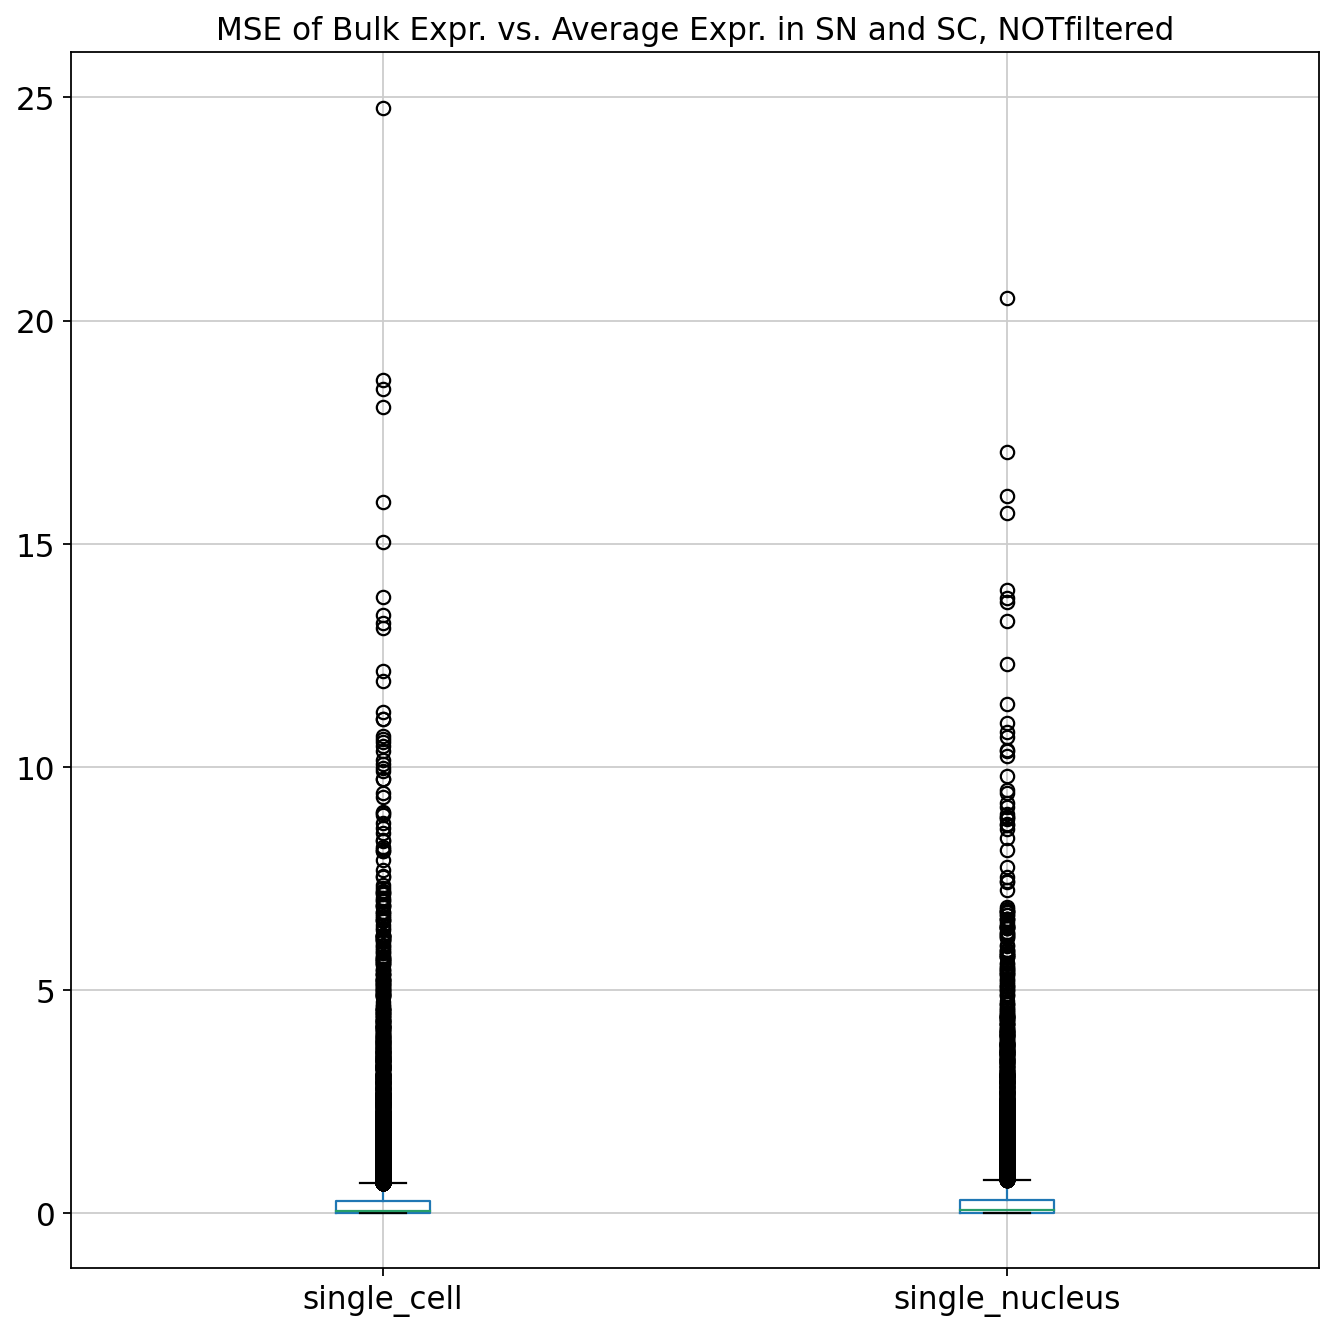

In [ ]:
plt.figure(figsize= [10,10])
mse_both.boxplot(column = ['single_cell', 'single_nucleus'])
plt.title('MSE of Bulk Expr. vs. Average Expr. in SN and SC, NOTfiltered')
#mean square error plot:

In [ ]:
#lastly saving results
sn_adata.write(f"{processed_path}M7_sn_notfiltered_scaled.h5ad")
sc_adata.write(f"{processed_path}M7_sc_notfiltered_scaled.h5ad")
bulk_adata.write(f"{processed_path}M7_bulk_notfiltered_scaled.h5ad")
single_adata_inner.write(f"{processed_path}M7_singlecombined_notfiltered_scaled.h5ad")
